In [1]:
import warnings
warnings.simplefilter('ignore')
import json
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
from IPython.display import display, HTML
import sklearn
from sklearn import tree
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline


#import os
#from numpy.random import randn
#from copy import copy
#from update import update

# Data Preprocessing

In [2]:
dataset_filename ='./roam_predcription_based_predicition_c.jsonl'
dataframe_main = pd.DataFrame()
data = ''
with open(dataset_filename) as json_data:
        data = json.load(json_data)
        dataframe_main= json_normalize(data)
json_data.close()


In [3]:
dataframe_main.shape

(239930, 2405)

In [4]:
dataframe_main.describe()

,cms_prescription_counts.1ST TIER UNIFINE PENTIPS,cms_prescription_counts.ABACAVIR,cms_prescription_counts.ABELCET,cms_prescription_counts.ABILIFY,cms_prescription_counts.ABILIFY DISCMELT,cms_prescription_counts.ABILIFY MAINTENA,cms_prescription_counts.ABRAXANE,cms_prescription_counts.ABSTRAL,cms_prescription_counts.ACAMPROSATE CALCIUM,cms_prescription_counts.ACANYA,...,cms_prescription_counts.ZYLOPRIM,cms_prescription_counts.ZYMAXID,cms_prescription_counts.ZYPREXA,cms_prescription_counts.ZYPREXA RELPREVV,cms_prescription_counts.ZYPREXA ZYDIS,cms_prescription_counts.ZYTIGA,cms_prescription_counts.ZYVOX,provider_variables.brand_name_rx_count,provider_variables.generic_rx_count,provider_variables.years_practicing
count,10.000000,828.000000,9.000000,20288.000000,81.000000,253.000000,5.000000,1.0,14.000000,1.0,...,6.000000,23.000000,785.000000,144.000000,137.000000,1377.000000,90.000000,239930.000000,239930.000000,239930.000000
mean,12.300000,26.421498,18.222222,67.318858,14.679012,19.956522,20.400000,11.0,14.500000,12.0,...,12.166667,28.521739,15.775796,35.604167,14.927007,23.652142,16.100000,176.264144,795.547047,6.241875
std,2.162817,20.192960,6.514940,83.135411,7.424330,12.300555,13.464769,NaN,2.928638,NaN,...,0.408248,17.783725,6.512600,58.602277,5.310416,19.475095,9.346092,475.159281,1809.618284,1.649269
min,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.0,11.000000,12.0,...,12.000000,12.000000,11.000000,11.000000,11.000000,11.000000,11.000000,0.000000,0.000000,1.000000
25%,11.000000,13.000000,14.000000,19.000000,11.000000,12.000000,13.000000,11.0,12.250000,12.0,...,12.000000,16.000000,12.000000,14.000000,12.000000,13.000000,11.000000,0.000000,36.000000,6.000000
50%,11.500000,19.000000,16.000000,38.000000,12.000000,16.000000,16.000000,11.0,14.500000,12.0,...,12.000000,20.000000,13.000000,22.000000,13.000000,18.000000,13.000000,15.000000,145.000000,7.000000
75%,12.750000,31.000000,20.000000,83.000000,14.000000,22.000000,18.000000,11.0,15.750000,12.0,...,12.000000,37.500000,17.000000,36.000000,16.000000,26.000000,15.750000,154.000000,750.000000,7.000000
max,18.000000,180.000000,29.000000,2120.000000,69.000000,99.000000,44.000000,11.0,19.000000,12.0,...,13.000000,78.000000,50.000000,641.000000,38.000000,229.000000,66.000000,30547.000000,101079.000000,8.000000


**simplifie the column name
<br/>check fro repeating column names
<br/> Check for invalide column name like white spaces etc**

### Remove the prefixes 'cms_prescription_counts', 'provider_variables' from the column names

In [5]:
#parts = (label.strip().split('.') for label in dataframe_main.columns.values)
column_names_list = dataframe_main.columns.values.tolist()
index_npi = column_names_list.index('npi')
column_names_list.remove('npi')

parts = [lable.strip(' \t\n\r').split('.',1) for lable in column_names_list] 
parts1 =  [parts_iter[0] for parts_iter in parts]
#len(parts)
column_name_new =  [parts_iter[1] for parts_iter in parts]
column_name_new.insert(index_npi,'npi')
#print index_npi
print len(column_name_new)

2405


create a dataframe out of parts and use shape to check if there are any rows with more than two values

In [6]:
df_check = pd.DataFrame(parts)
df_check.shape

(2404, 2)

There are only 2 columns

create a dataframe out of parts1 and see if all the name are either  'cms_prescription_counts' or 
'provider_variables'. use groupby() to do this


In [7]:
#parts1.append(' ')
df_names_check = pd.DataFrame(parts1, columns=['titles'])
counts = df_names_check.groupby(["titles"]).size()
display (counts)
print "total number of rows is:", len(df_names_check['titles'])
print "cms_prescription_counts + provider_variables", counts['cms_prescription_counts']+counts['provider_variables']

titles
cms_prescription_counts    2397
provider_variables            7
dtype: int64

total number of rows is: 2404
cms_prescription_counts + provider_variables 2404


The sum of number of cms_prescription_counts's and provider_variables's is correct(1 less because we removed 'npi') and we cannot see and invalid entries 
<br/>And target variables are as expected 7

In [8]:
print len(column_names_list)

2404


now check column_name_new for duplicates and invalid names like ''

In [9]:
column_name_new_striped = [x.strip(' \t\n\r') for x in column_name_new]
print len(column_name_new_striped)
#print column_name_new_striped

df_new_names_check = pd.DataFrame(column_name_new_striped, columns=['label']).groupby(['label']).size().reset_index()
df_new_names_check.columns = ['label', 'counts']

display (df_new_names_check.query("counts != 1" ))
display (df_new_names_check.query(("label == ''")))
display (df_new_names_check.query("label == ' '"))


df_new_names_check.mean()

2405


,label,counts


,label,counts


,label,counts


counts    1.0
dtype: float64

The mean is 1.0 which mean all the labels appear only once and there are no duplicates also there are no empty string for column names 

Now remove the cms_prescription_counts and provider_variables from the titles and have a cleaner names

replace the column name inplace uisng the lists column_names_list and column_name_new_striped

In [10]:
column_names_list.insert(index_npi,'npi')

#dataframe_main.columns = column_name_new_striped
new_names_dict = {}
for i in range(0,len(column_names_list)):
    new_names_dict[column_names_list[i]] =  column_name_new_striped[i]
print len(new_names_dict)

2405


In [11]:
dataframe_main.rename(columns=new_names_dict, inplace=True)

In [12]:
dataframe_main.columns.values[-10:]

array([u'ZYTIGA', u'ZYVOX', 'npi', u'brand_name_rx_count', u'gender',
       u'generic_rx_count', u'region', u'settlement_type', u'specialty',
       u'years_practicing'], dtype=object)

**Uniqueness of npi**

</br>Check for dupliate values of "npi".

In [13]:
df_npi_dulicates= pd.DataFrame(dataframe_main["npi"],columns=['npi']).duplicated("npi",keep=False).to_frame(name="res")
df_npi_dulicates.groupby('res').size()

res
False    239930
dtype: int64

There are no duplicates in the npi

In [14]:
df_specialty_count = pd.DataFrame({'counts' : dataframe_main.groupby( [ "specialty"] , sort=False).size()}).reset_index()
df_specialty_count.sort_values(['counts'], ascending=True, inplace=True)
df_specialty_count.head(20)

,specialty,counts
281,Continuing Education/Staff Development,1
250,"Nursing Care, Pediatric",1
249,Pulmonary Diagnostics,1
247,Chronic Care,1
245,"Family Planning, Non-Surgical",1
242,Neuropathology,1
238,In Vivo & In Vitro Nuclear Medicine,1
235,Forensic Pathology,1
234,Long-Term Care,1
231,Pastoral,1


## Data Exploration

In [15]:
def validRowsForSpecialty(specialty,how):
    temp = dataframe_main.ix[dataframe_main.specialty == specialty]
    temp.dropna(axis=1,how='all', inplace=True) #delete columns that are all NaN
    temp1 = temp.columns.values   #these are the columns corresponding to the given specialty 
    temp1 = temp1[:-8]        # deleting unnecessary column names npi ,brand_name_rx_count ,gender ,generic_rx_count ,region ,settlement_type ,specialty and years_practicing
    temp2 = np.append(temp1, 'specialty') 

    dataframe_MaternalNewborn_columns = dataframe_main[temp2]
    dataframe_MaternalNewborn_columns.dropna(axis=0, how=how, subset=temp1, inplace=True) # delete row that have any/all NaN values
    display(dataframe_MaternalNewborn_columns)
    

    


In [16]:
validRowsForSpecialty('Behavioral Neurology & Neuropsychiatry', 'all')

,ABILIFY,ALLOPURINOL,ALPRAZOLAM,AMANTADINE,AMBIEN,AMBIEN CR,AMITRIPTYLINE HCL,AMLODIPINE BESYLATE,AMPHETAMINE SALT COMBO,BACLOFEN,...,TRIFLUOPERAZINE HCL,TRIHEXYPHENIDYL HCL,VENLAFAXINE HCL,VENLAFAXINE HCL ER,VYVANSE,WELLBUTRIN XL,ZIPRASIDONE HCL,ZOLPIDEM TARTRATE,ZYPREXA,specialty
0,11.0,86.0,45.0,NaN,NaN,NaN,NaN,175.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.0,NaN,Nephrology
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,General Practice
4,NaN,19.0,NaN,NaN,NaN,NaN,NaN,79.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.0,NaN,Nephrology
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,General Practice
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gastroenterology
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN,Psychiatry
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,General Practice
12,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rheumatology
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gastroenterology
15,NaN,NaN,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,NaN,Plastic and Reconstructive Surgery


In [17]:
validRowsForSpecialty('Behavioral Neurology & Neuropsychiatry', 'any')

,ABILIFY,ALLOPURINOL,ALPRAZOLAM,AMANTADINE,AMBIEN,AMBIEN CR,AMITRIPTYLINE HCL,AMLODIPINE BESYLATE,AMPHETAMINE SALT COMBO,BACLOFEN,...,TRIFLUOPERAZINE HCL,TRIHEXYPHENIDYL HCL,VENLAFAXINE HCL,VENLAFAXINE HCL ER,VYVANSE,WELLBUTRIN XL,ZIPRASIDONE HCL,ZOLPIDEM TARTRATE,ZYPREXA,specialty


In [18]:
validRowsForSpecialty('Psychiatry', 'any')

,ABILIFY,ABILIFY DISCMELT,ABILIFY MAINTENA,ACAMPROSATE CALCIUM,ACARBOSE,ACCUPRIL,ACEBUTOLOL HCL,ACETAMINOPHEN-BUTALBITAL,ACETAMINOPHEN-CODEINE,ACETAZOLAMIDE,...,ZOMIG ZMT,ZONEGRAN,ZONISAMIDE,ZOSTAVAX,ZOVIA 1-35E,ZYMAXID,ZYPREXA,ZYPREXA RELPREVV,ZYPREXA ZYDIS,specialty


In [19]:
temp4 = dataframe_main.ix[dataframe_main.specialty == 'Psychiatry']
temp4.dropna(axis=1, how='all', inplace=True)
temp4.shape

(22530, 1036)

In [20]:
validRowsForSpecialty('Maternal Newborn', 'any')

,AZURETTE,ESTRACE,JUNEL FE,MEDROXYPROGESTERONE ACETATE,PREMARIN,specialty
17686,15.0,11.0,32.0,16.0,31.0,Maternal Newborn


In [21]:
validRowsForSpecialty('Maternal Newborn', 'all')

,AZURETTE,ESTRACE,JUNEL FE,MEDROXYPROGESTERONE ACETATE,PREMARIN,specialty
62,NaN,NaN,NaN,21.0,NaN,Medical
92,NaN,NaN,NaN,NaN,22.0,Gynecology
109,NaN,NaN,NaN,NaN,22.0,Pulmonary Disease
131,NaN,NaN,NaN,NaN,17.0,Women's Health
322,NaN,NaN,NaN,NaN,12.0,Family
348,NaN,17.0,NaN,43.0,107.0,Gynecology
356,NaN,18.0,NaN,NaN,32.0,Family
400,NaN,48.0,NaN,NaN,NaN,Gynecologic Oncology
406,NaN,NaN,NaN,NaN,50.0,Family
411,NaN,NaN,NaN,NaN,14.0,Family


In [22]:
validRowsForSpecialty('Dental Public Health', 'all')

,ACETAMINOPHEN-CODEINE,ALPRAZOLAM,AMOX TR-POTASSIUM CLAVULANATE,AMOXICILLIN,AMPICILLIN TRIHYDRATE,AZITHROMYCIN,CEFADROXIL,CEPHALEXIN,CHLORHEXIDINE GLUCONATE,CIPROFLOXACIN HCL,...,POTASSIUM CHLORIDE,PREVIDENT 5000,PREVIDENT 5000 PLUS,PREVIDENT 5000 SENSITIVE,SF,SF 5000 PLUS,TRAMADOL HCL,TRAZODONE HCL,ZOLPIDEM TARTRATE,specialty
0,NaN,45.0,NaN,NaN,NaN,18.0,NaN,NaN,NaN,19.0,...,30.0,NaN,NaN,NaN,NaN,NaN,11.0,NaN,41.0,Nephrology
1,NaN,NaN,NaN,52.0,NaN,NaN,NaN,23.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,General Practice
2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,28.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,General Practice
3,NaN,NaN,NaN,63.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,General Practice
4,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.0,Nephrology
5,NaN,NaN,NaN,40.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,General Practice
6,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,General Practice
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Endodontics
8,NaN,NaN,15.0,NaN,NaN,31.0,NaN,17.0,NaN,14.0,...,33.0,NaN,NaN,NaN,NaN,NaN,NaN,65.0,NaN,Gastroenterology
9,NaN,NaN,NaN,27.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,General Practice


In [23]:
validRowsForSpecialty('Dental Public Health', 'any')

,ACETAMINOPHEN-CODEINE,ALPRAZOLAM,AMOX TR-POTASSIUM CLAVULANATE,AMOXICILLIN,AMPICILLIN TRIHYDRATE,AZITHROMYCIN,CEFADROXIL,CEPHALEXIN,CHLORHEXIDINE GLUCONATE,CIPROFLOXACIN HCL,...,POTASSIUM CHLORIDE,PREVIDENT 5000,PREVIDENT 5000 PLUS,PREVIDENT 5000 SENSITIVE,SF,SF 5000 PLUS,TRAMADOL HCL,TRAZODONE HCL,ZOLPIDEM TARTRATE,specialty


In [24]:
validRowsForSpecialty('Surgery of the Hand', 'all')
validRowsForSpecialty('Surgery of the Hand', 'any')

,ACETAMINOPHEN-CODEINE,ACYCLOVIR,ALLOPURINOL,ALPRAZOLAM,AMITRIPTYLINE HCL,AMLODIPINE BESYLATE,AMOX TR-POTASSIUM CLAVULANATE,AMOXICILLIN,ATENOLOL,ATORVASTATIN CALCIUM,...,TRAMADOL HCL,TRAMADOL HCL-ACETAMINOPHEN,TRETINOIN,TRIAMCINOLONE ACETONIDE,VALACYCLOVIR,VESICARE,VOLTAREN,ZOLPIDEM TARTRATE,ZOSTAVAX,specialty
0,NaN,NaN,86.0,45.0,NaN,175.0,NaN,NaN,62.0,19.0,...,11.0,NaN,NaN,NaN,NaN,NaN,NaN,41.0,NaN,Nephrology
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,General Practice
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,General Practice
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,General Practice
4,NaN,NaN,19.0,NaN,NaN,79.0,NaN,12.0,48.0,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.0,NaN,Nephrology
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,General Practice
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,General Practice
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Endodontics
8,NaN,NaN,NaN,NaN,NaN,69.0,15.0,NaN,NaN,68.0,...,NaN,NaN,NaN,15.0,NaN,NaN,17.0,NaN,NaN,Gastroenterology
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,General Practice


,ACETAMINOPHEN-CODEINE,ACYCLOVIR,ALLOPURINOL,ALPRAZOLAM,AMITRIPTYLINE HCL,AMLODIPINE BESYLATE,AMOX TR-POTASSIUM CLAVULANATE,AMOXICILLIN,ATENOLOL,ATORVASTATIN CALCIUM,...,TRAMADOL HCL,TRAMADOL HCL-ACETAMINOPHEN,TRETINOIN,TRIAMCINOLONE ACETONIDE,VALACYCLOVIR,VESICARE,VOLTAREN,ZOLPIDEM TARTRATE,ZOSTAVAX,specialty


In [25]:
validRowsForSpecialty('Sleep Medicine', 'all')
validRowsForSpecialty('Sleep Medicine', 'any')

,ABILIFY,ACETAMINOPHEN-CODEINE,ACETAZOLAMIDE,ACTONEL,ACYCLOVIR,ADDERALL,ADDERALL XR,ADVAIR DISKUS,ADVICOR,AGGRENOX,...,ZETIA,ZIPRASIDONE HCL,ZOLMITRIPTAN,ZOLPIDEM TARTRATE,ZOLPIDEM TARTRATE ER,ZOLPIMIST,ZONEGRAN,ZONISAMIDE,ZOSTAVAX,specialty
0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,41.0,NaN,NaN,NaN,NaN,NaN,Nephrology
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,General Practice
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,General Practice
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,General Practice
4,NaN,NaN,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,35.0,NaN,NaN,NaN,NaN,NaN,Nephrology
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,General Practice
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,General Practice
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Endodontics
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gastroenterology
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,General Practice


,ABILIFY,ACETAMINOPHEN-CODEINE,ACETAZOLAMIDE,ACTONEL,ACYCLOVIR,ADDERALL,ADDERALL XR,ADVAIR DISKUS,ADVICOR,AGGRENOX,...,ZETIA,ZIPRASIDONE HCL,ZOLMITRIPTAN,ZOLPIDEM TARTRATE,ZOLPIDEM TARTRATE ER,ZOLPIMIST,ZONEGRAN,ZONISAMIDE,ZOSTAVAX,specialty


This show that the drugs prescribed for Dental Public Health are not completely specific to this specialty only but are also prescribed by other specialties
there
fore these  drugs cannot give us any clear indicators for prediction

this shows that the columns Azurette, Estrac, Junel FE, MEDROXYPROGESTERONE ACETATE and premarin are filled only for the specilization Maternal Newborn

# Exploratory Visualization

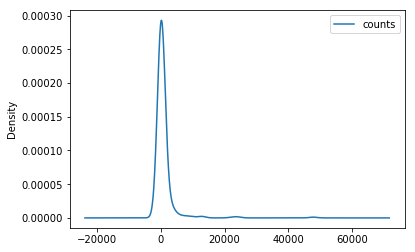

In [26]:
df_specialty_count.plot.density()

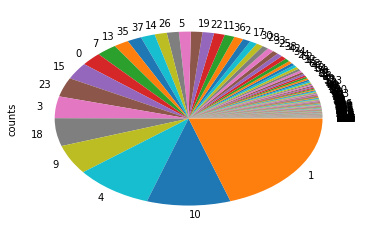

In [27]:
df_specialty_count.plot.pie(x=0,y=1,
                           title ='',
                           grid =True,
                            legend=False
                           )


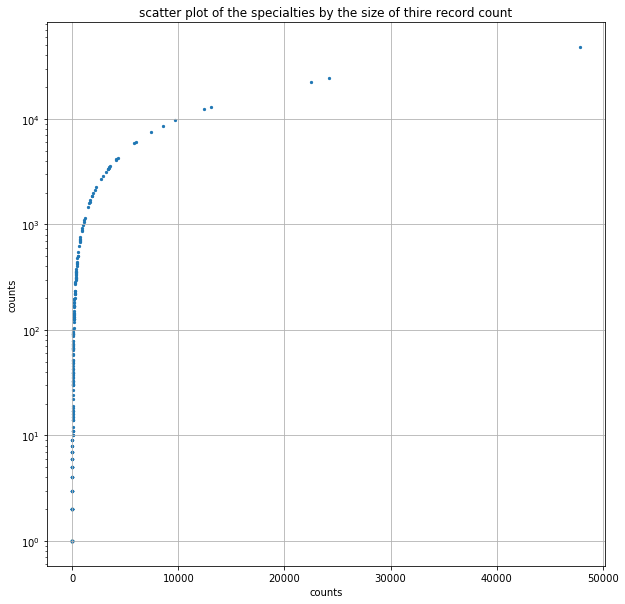

In [28]:

df_specialty_count.plot.scatter(x=1,#'record_count',
                                y=1, 
                                logy =True,
                                use_index =True,
                                grid=True,
                                s=5,
                                figsize=(10,10),
                                title='scatter plot of the specialties by the size of thire record count'                             
                        )

,gender,record_count
0,F,90273
1,M,149657


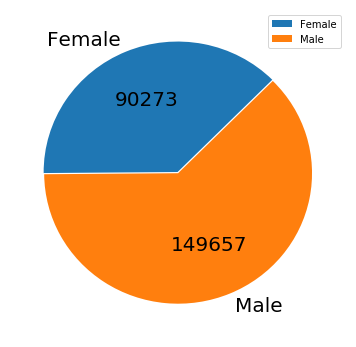

In [29]:
#df["gender"].describe()
df_gender = dataframe_main.groupby(['gender']).size().reset_index(name='record_count')
#print "number of :", df_gender.count()
display (df_gender)
df_gender.describe()

import pylab
df_gender.plot.pie(y='record_count', subplots=True, labels=['Female', 'Male'], 
                   autopct=lambda(p): '{:.0f}'.format(p * 239930 / 100),
                   fontsize=20, figsize=(6, 6), explode=(0.01, 0.0),
                   startangle=45
                  )
pylab.axes().set_ylabel('')

,years_practicing,record_count
0,1,7458
1,2,7735
2,3,7737
3,4,8187
4,5,13306
5,6,47160
6,7,117540
7,8,30807


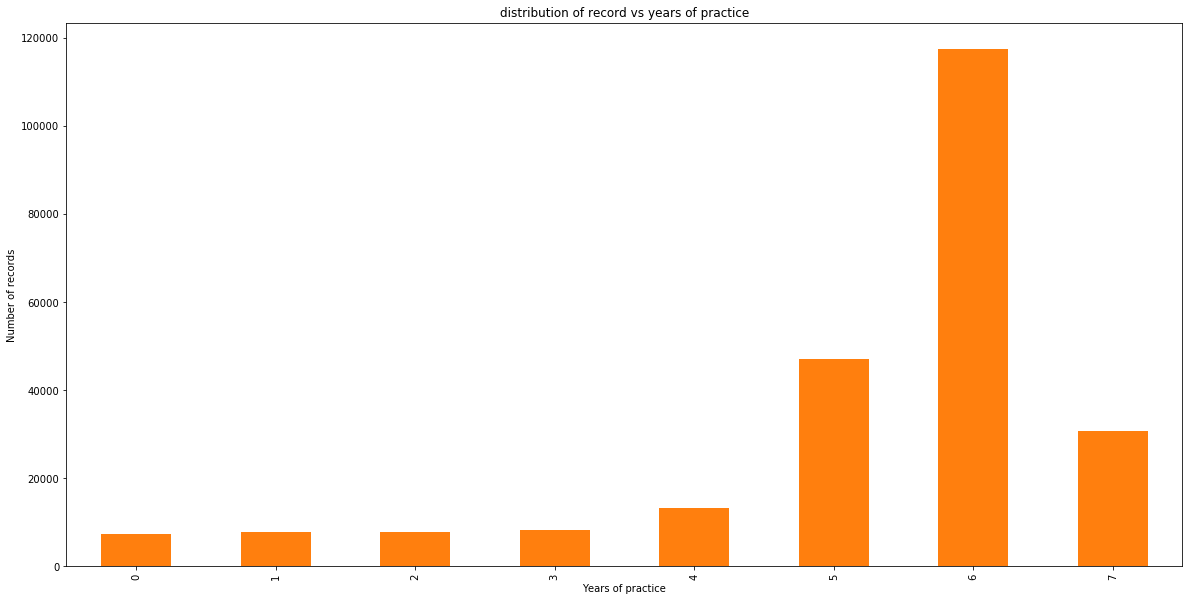

In [30]:
#df["years_practicing"].describe()
df_years_practicing = dataframe_main.groupby(['years_practicing']).size().reset_index(name='record_count')
display (df_years_practicing)
df_years_practicing.describe()

my_plot = df_years_practicing.plot(kind='bar',legend =False, stacked=True,
                                   title="distribution of record vs years of practice", 
                                   figsize=(20,10))
my_plot.set_xlabel("Years of practice")
my_plot.set_ylabel("Number of records")

,region,record_count
0,Midwest,50077
1,Northeast,59012
2,South,80562
3,West,50279


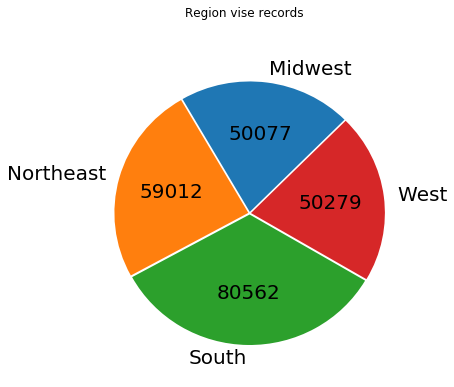

In [31]:
#dataframe_main["region"].describe()
df_region = dataframe_main.groupby(['region']).size().reset_index(name='record_count')
display (df_region)
df_region.describe()

df_region.plot.pie(y='record_count', subplots=True, labels=df_region['region'], 
                   autopct=lambda(p): '{:.0f}'.format(p * 239930 / 100),
                   fontsize=20, figsize=(6, 6), explode=(0.01, 0.01,0.01,0.01),
                   startangle=45,legend=False,
                   title="Region vise records"
                  )
pylab.axes().set_ylabel('')

,settlement_type,record_count
0,non-urban,152270
1,urban,87660


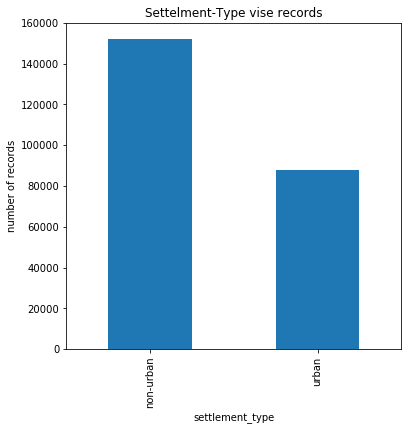

In [32]:
#dataframe_main["settlement_type"].describe()
df_settlement_type = dataframe_main.groupby(['settlement_type']).size().reset_index(name='record_count')
display (df_settlement_type)
df_settlement_type.describe()

df_settlement_type.plot.bar(x='settlement_type',
                            y='record_count',
                            subplots=False,
                            figsize=(6, 6),
                            legend=False,
                            title="Settelment-Type vise records"
                  )
pylab.axes().set_ylabel('number of records')

In [33]:
dataframe_main["generic_rx_count"].describe()


count    239930.000000
mean        795.547047
std        1809.618284
min           0.000000
25%          36.000000
50%         145.000000
75%         750.000000
max      101079.000000
Name: generic_rx_count, dtype: float64

In [34]:
dataframe_main["brand_name_rx_count"].describe()

count    239930.000000
mean        176.264144
std         475.159281
min           0.000000
25%           0.000000
50%          15.000000
75%         154.000000
max       30547.000000
Name: brand_name_rx_count, dtype: float64

within the specialty General Practice is there any trend to suggest 
    1) different doctors from different regions tend to prescribe differently
    2) different doctors from different settlement's tend to prescribe differently
    3) doctors of different years of practice tend to prescribe differently

In [35]:
df_specialty_count.sort_values(['counts'], ascending=False, inplace=True)
type (df_specialty_count)
display (df_specialty_count.head(40))

,specialty,counts
1,General Practice,47836
10,Family,24230
4,Psychiatry,22530
9,Cardiovascular Disease,13091
18,Medical,12445
3,Gastroenterology,9695
23,Neurology,8501
15,Adult Health,7444
0,Nephrology,5997
7,Hematology & Oncology,5852


In [36]:
print 'number of specialties with rows fewer than '

print '100 are \t\t', df_specialty_count.query('counts <= 100').shape[0]
print '200 are \t\t', df_specialty_count.query('counts > 100 and counts <= 200').shape[0]
print '300 are \t\t', df_specialty_count.query('counts > 200 and counts <= 300').shape[0]
print '400 are \t\t', df_specialty_count.query('counts > 300 and counts <= 400').shape[0]
print '400 to 1000 are \t', df_specialty_count.query('counts > 400 and counts <= 1000').shape[0]
print '1000 to 2000 are \t', df_specialty_count.query('counts > 1000 and counts <= 2000').shape[0]
print '2000 to 3000 are \t', df_specialty_count.query('counts > 2000 and counts <= 3000').shape[0]
print '3000 to 4000 are \t', df_specialty_count.query('counts > 3000 and counts <= 4000').shape[0]
print '4000 to 5000 are \t', df_specialty_count.query('counts > 4000 and counts <= 5000').shape[0]
#print '1000 are \t\t', df_specialty_count.query('counts > 900 and counts <= 1000').shape[0]
#print '1000 to 5000 are \t', df_specialty_count.query('counts > 1000 and counts <= 5000').shape[0]

print '\n\ngreater than 5000 \t', df_specialty_count.query('counts > 5000').shape[0]


number of specialties with rows fewer than 
100 are 		189
200 are 		21
300 are 		10
400 are 		11
400 to 1000 are 	18
1000 to 2000 are 	10
2000 to 3000 are 	4
3000 to 4000 are 	6
4000 to 5000 are 	3


greater than 5000 	10


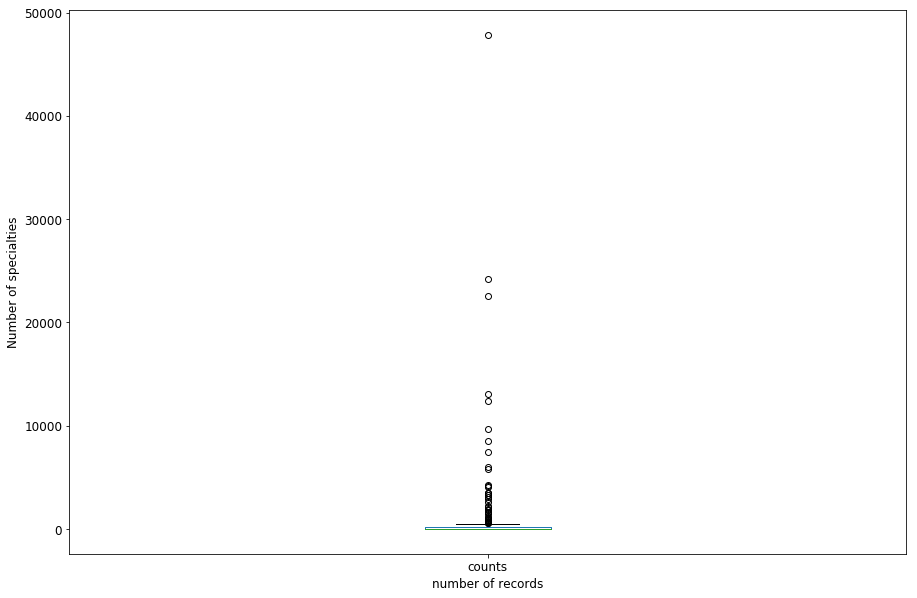

In [37]:
import matplotlib.pyplot as plt
ax = df_specialty_count[['counts','specialty']].plot(kind='box',  figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("number of records", fontsize=12)
ax.set_ylabel("Number of specialties", fontsize=12)
plt.show()

There are columns with very few rows can cause data appear skwed.  With entries as few as 1 or 2 these values can appear as outliers.


In [38]:
#This function shall be used to identify the columns that have very few entries 
# these columns will not be of much use to analyse any pattern 

def columnsWithVeryFewValues(df_specialty_GP, percent):
    fewENtriesCount = 0
    validRowValues = int(df_specialty_GP.shape[0]*percent/100) #atleast 0.5% of rows have valid entries
    fewENtriesColumns = []

    for feature in df_specialty_GP.columns.values:
        a = df_specialty_GP[feature].count()
        if validRowValues > a:
            fewENtriesColumns.append(feature)
            fewENtriesCount = fewENtriesCount+1
    print "There are ", fewENtriesCount, "columns out of ",len(df_specialty_GP.keys()), "with less than " , validRowValues, " entries" 
    return fewENtriesColumns


In [39]:
def top20columns(specialty):
    df_specialty = dataframe_main[dataframe_main.specialty == specialty]
    df_specialty.drop(
            ['npi', 'gender','brand_name_rx_count', 'generic_rx_count','settlement_type', 'region','years_practicing' ]
            , axis=1, inplace=True)
    df_specialty.dropna(axis=1, how='all', inplace=True)
    df_specialty_sum = df_specialty.groupby(["specialty"]).sum()
    df_specialty_count = df_specialty.groupby(["specialty"]).count()#.reset_index()

    df_specialty_count_T = df_specialty_count.transpose().reset_index()
    df_specialty_count_T.sort_values(specialty,axis=0, ascending=False, inplace=True)

    columns_to_keep = df_specialty_count_T.head(20)['index'].tolist()
    df_specialty = df_specialty[columns_to_keep]
    return df_specialty

In [40]:

def plotSettlementBasedDistribution(df_specialty_SType, specialty):
    
    #df_specialty_GP.groupby(["settlement_type"]).size()

    df_specialty_count = df_specialty_SType.groupby(["settlement_type"]).count()
    df_specialty_sum = df_specialty_SType.groupby(["settlement_type"], as_index=True).sum()
    
    df_specialty_count_T = df_specialty_count.transpose()
    df_specialty_sum_T = df_specialty_sum.transpose()

    #df_specialty_count_sum_T = pd.DataFrame(df_specialty_GP_count_T.values.sum(axis=1))

    df_specialty_normalized = pd.DataFrame((df_specialty_sum_T.values / df_specialty_count_T.values)                                 
                                     , columns=[elt for elt in df_specialty_sum_T.columns + "_normalized"]
                                     , index=df_specialty_count_T.index)

    my_plot = df_specialty_normalized.plot(kind='bar',stacked=False,title="Settlement-Type vise distribution for "+specialty, figsize=(20,10) )
    #my_plot.set_xlabel("Drugs")
    my_plot.set_ylabel("Average count per record")
    

    #find the lesser of the two settlements
    array_lesser = np.where((df_specialty_normalized['non-urban_normalized']<df_specialty_normalized['urban_normalized']),
                                df_specialty_normalized['non-urban_normalized'], df_specialty_normalized['urban_normalized'])

    df_specialty_percent_diff = pd.DataFrame((abs(df_specialty_normalized['non-urban_normalized']-df_specialty_normalized['urban_normalized'])), columns=['difference'])

    df_specialty_percent_diff['Lesser'] = array_lesser

    df_specialty_percent_diff['percentage'] = pd.DataFrame(df_specialty_percent_diff.difference / df_specialty_percent_diff.Lesser * 100)

    if 'difference' in df_specialty_percent_diff.columns:
        df_specialty_percent_diff = df_specialty_percent_diff.drop(['difference' ], axis=1, inplace=False)

    if 'Lesser' in df_specialty_percent_diff.columns:
        df_specialty_percent_diff = df_specialty_percent_diff.drop( ['Lesser' ], axis=1, inplace=False)


    #my_plot = df_specialty_percent_diff.plot(kind='bar',stacked=False,title="Settlement-Type vise distribution for "+specialty, figsize=(15,5))
    #my_plot.set_xlabel("Drugs")
    #my_plot.set_ylabel("Percentage difference")

In [41]:
def plotRegionBasedDistribution(df_specialty_Region, specialty):
    df_specialty_Region_count = df_specialty_Region.groupby(["region"]).count()
    df_specialty_Region_sum = df_specialty_Region.groupby(["region"]).sum()

    df_specialty_Region_count_T = df_specialty_Region_count.transpose()
    df_specialty_Region_sum_T = df_specialty_Region_sum.transpose()
    
    df_specialty_Region_grouped_normalized = pd.DataFrame((df_specialty_Region_sum_T.values / df_specialty_Region_count_T.values)                                 
                                     , columns=[elt for elt in df_specialty_Region_sum_T.columns + "_normalized"]
                                     , index=df_specialty_Region_count_T.index)

    my_plot = df_specialty_Region_grouped_normalized.plot(kind='bar',stacked=False,title="Region vise distibution for "+specialty, figsize=(20,10))
    #my_plot.set_xlabel("Drugs")
    my_plot.set_ylabel("Average count per record")

In [42]:
def plotSTandRegionBasedDistribution(df_specialty_Re_ST, specialty):
    df_specialty_Region_ST_count = df_specialty_Re_ST.groupby(["region", "settlement_type"], as_index=False).count()
    df_specialty_Region_ST_sum = df_specialty_Re_ST.groupby(["region", "settlement_type"], as_index=False).sum()

    df_specialty_Region_ST_count['region-st'] = df_specialty_Region_ST_count[['region', 'settlement_type']].apply(lambda x: '_'.join(x), axis=1)
    df_specialty_Region_ST_sum['region-st'] = df_specialty_Region_ST_sum[['region', 'settlement_type']].apply(lambda x: '_'.join(x), axis=1)

    df_specialty_Region_ST_count = df_specialty_Region_ST_count.drop(['region', 'settlement_type'], axis=1, inplace=False)
    df_specialty_Region_ST_sum = df_specialty_Region_ST_sum.drop(['region', 'settlement_type'], axis=1, inplace=False)


    df_specialty_Region_ST_count = df_specialty_Region_ST_count.set_index("region-st")
    df_specialty_Region_ST_sum = df_specialty_Region_ST_sum.set_index("region-st")

    df_specialty_Region_ST_count_T = df_specialty_Region_ST_count.transpose()
    df_specialty_Region_ST_sum_T = df_specialty_Region_ST_sum.transpose()
    
    df_specialty_Region_ST_grouped_normalized = pd.DataFrame((df_specialty_Region_ST_sum_T.values / df_specialty_Region_ST_count_T.values)                                 
                                 , columns=[elt for elt in df_specialty_Region_ST_sum_T.columns + "_normalized"]
                                 , index=df_specialty_Region_ST_count_T.index)

    my_plot = df_specialty_Region_ST_grouped_normalized.plot(kind='bar',stacked=False,title="Region and Settlement-Type based distribution for "+specialty, figsize=(20,10))
    #my_plot.set_xlabel("Drugs")
    my_plot.set_ylabel("Average count per record")

In [46]:
def plotDistributions(specialty):
    df_specialty = dataframe_main[dataframe_main.specialty== specialty]
    df_specialty.dropna(axis=1, how='all', inplace=True)

    #Take out the necessary coulmns that will be use in future and drop the uncessary once
    df_specialty_ST = df_specialty['settlement_type']
    df_specialty_YP = df_specialty['years_practicing']
    df_specialty_Re = df_specialty['region']
    df_specialty_BrxC = df_specialty['brand_name_rx_count']
    df_specialty_GrxC = df_specialty['generic_rx_count']
    df_specialty_Gen = df_specialty['gender']

    df_specialty=top20columns(specialty)
    
    #plot SETTLEMENT-TYPE
    df_specialty_SType = df_specialty
    df_specialty_SType['settlement_type'] = df_specialty_ST
    plotSettlementBasedDistribution(df_specialty_SType, specialty)
    
    #PLOT REGION BASED
    df_specialty_Region = df_specialty.drop(['settlement_type'], axis=1, inplace=False)
    df_specialty_Region['region'] = df_specialty_Re
    plotRegionBasedDistribution(df_specialty_Region, specialty)
    
    #PLOT USING BOTH REGION AND SETTLEMENT-TYPE
    df_specialty_Re_ST = df_specialty
    df_specialty_Re_ST['region'] = df_specialty_Re
    plotSTandRegionBasedDistribution(df_specialty_Re_ST, specialty)
    #display(df_specialty_Re_ST)

In [44]:
top10specialties = df_specialty_count.head(10)
top10specialties.reset_index(None, inplace=True)
top10specialties.drop('index', axis=1, inplace=True)
top10specialties

,specialty,counts
0,General Practice,47836
1,Family,24230
2,Psychiatry,22530
3,Cardiovascular Disease,13091
4,Medical,12445
5,Gastroenterology,9695
6,Neurology,8501
7,Adult Health,7444
8,Nephrology,5997
9,Hematology & Oncology,5852


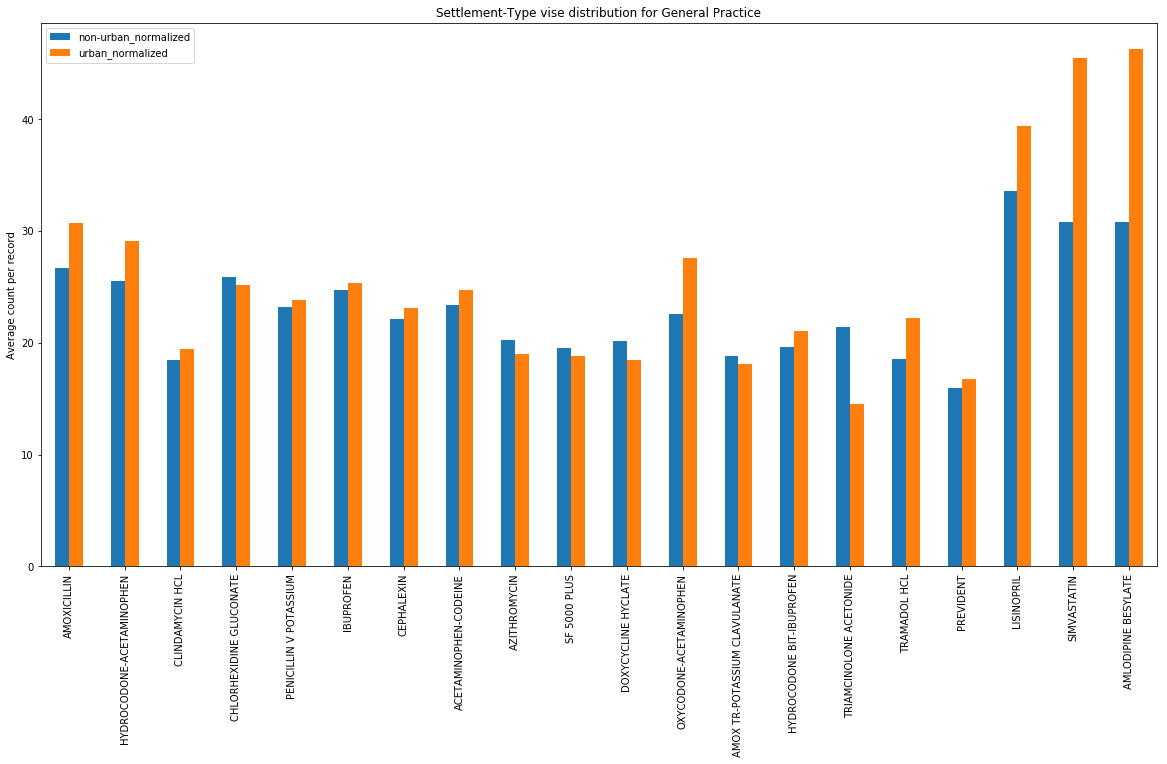

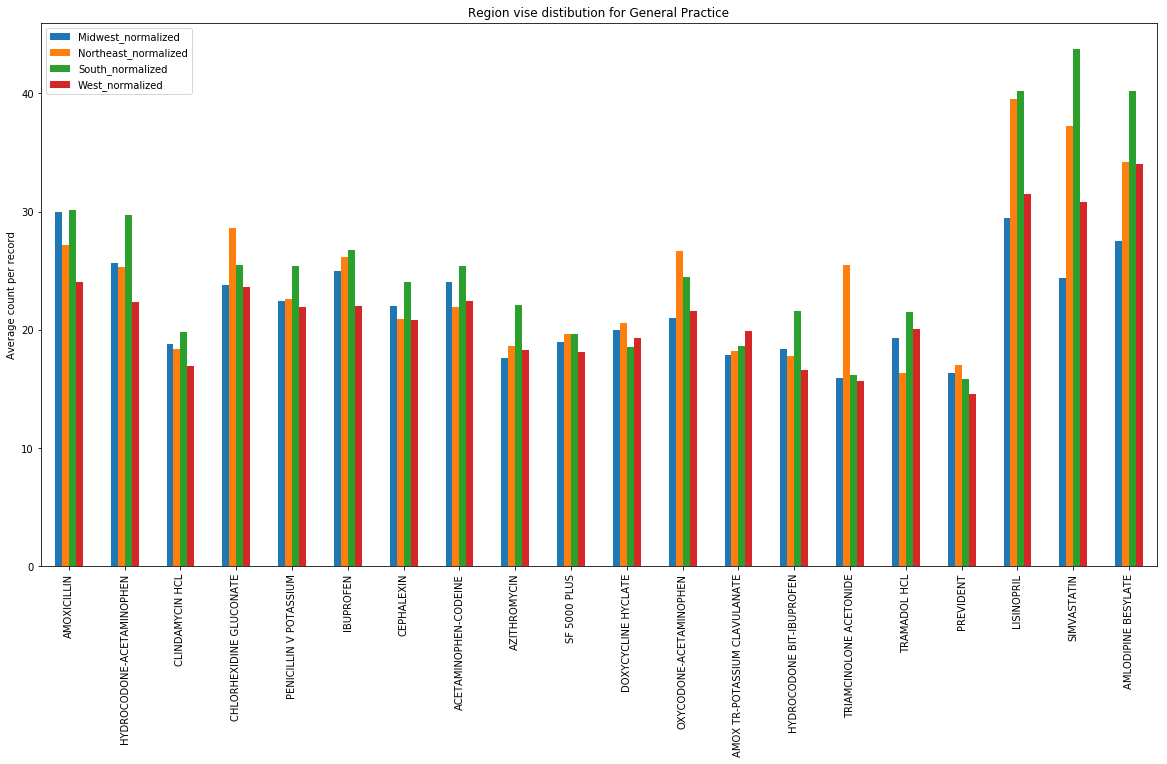

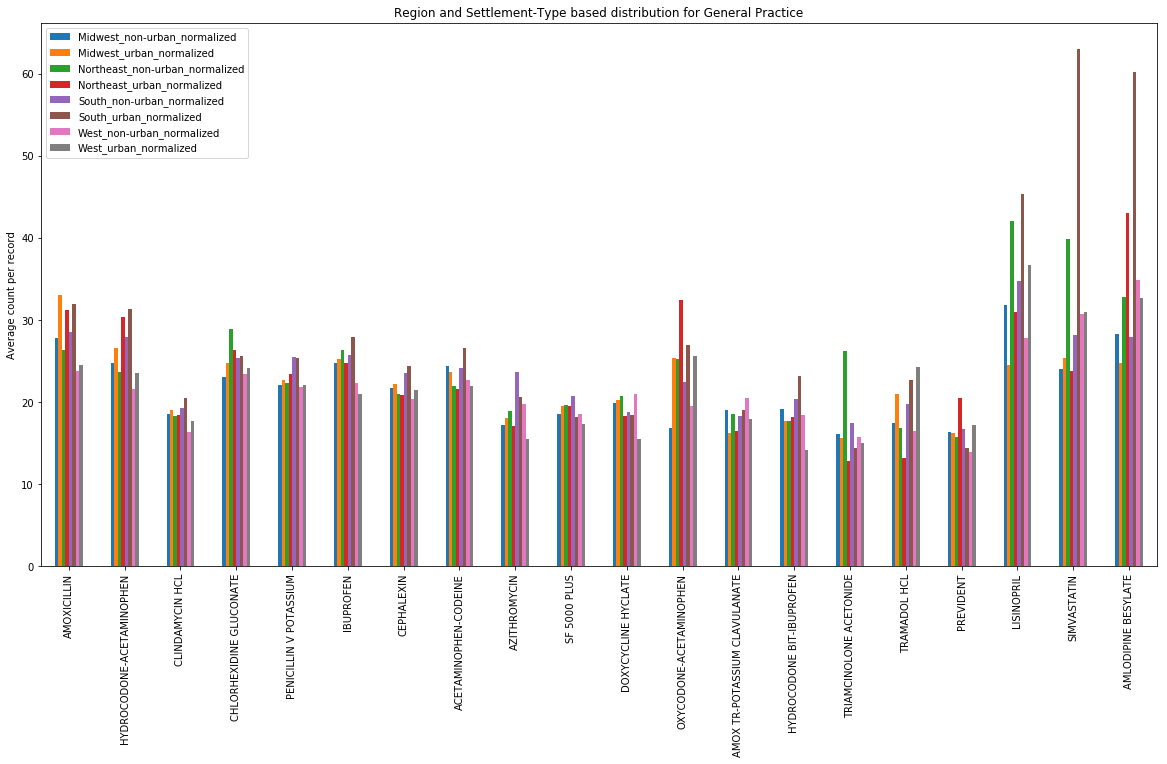

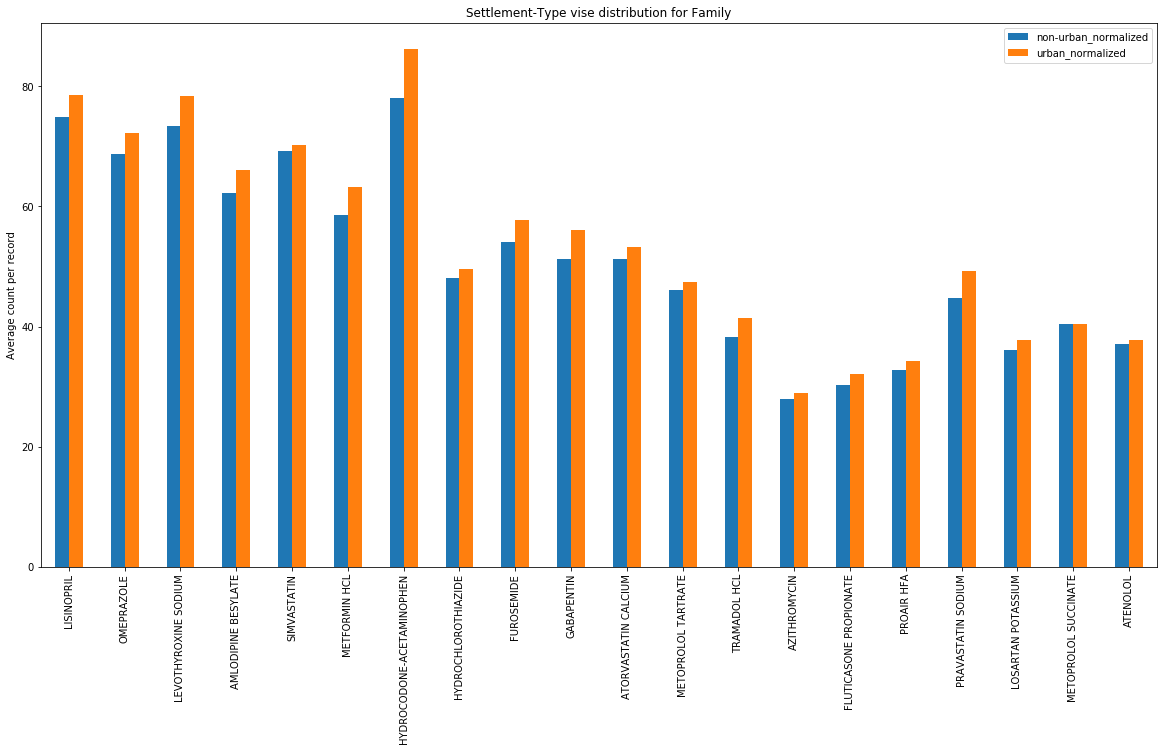

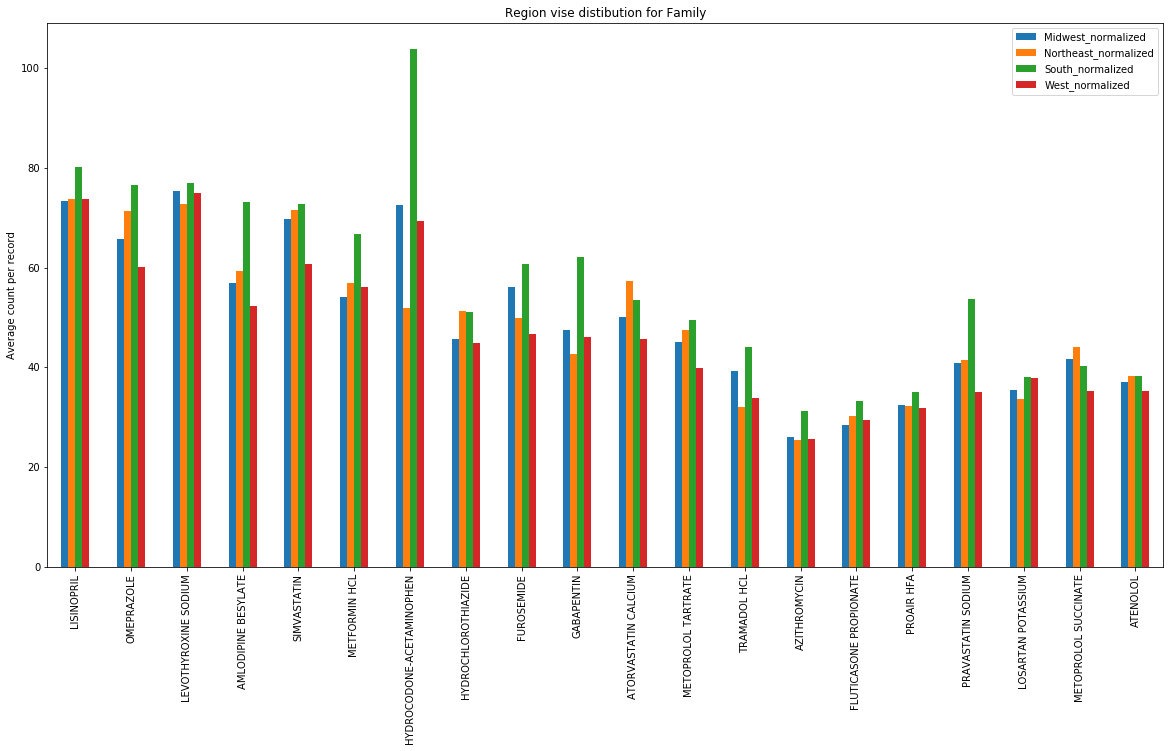

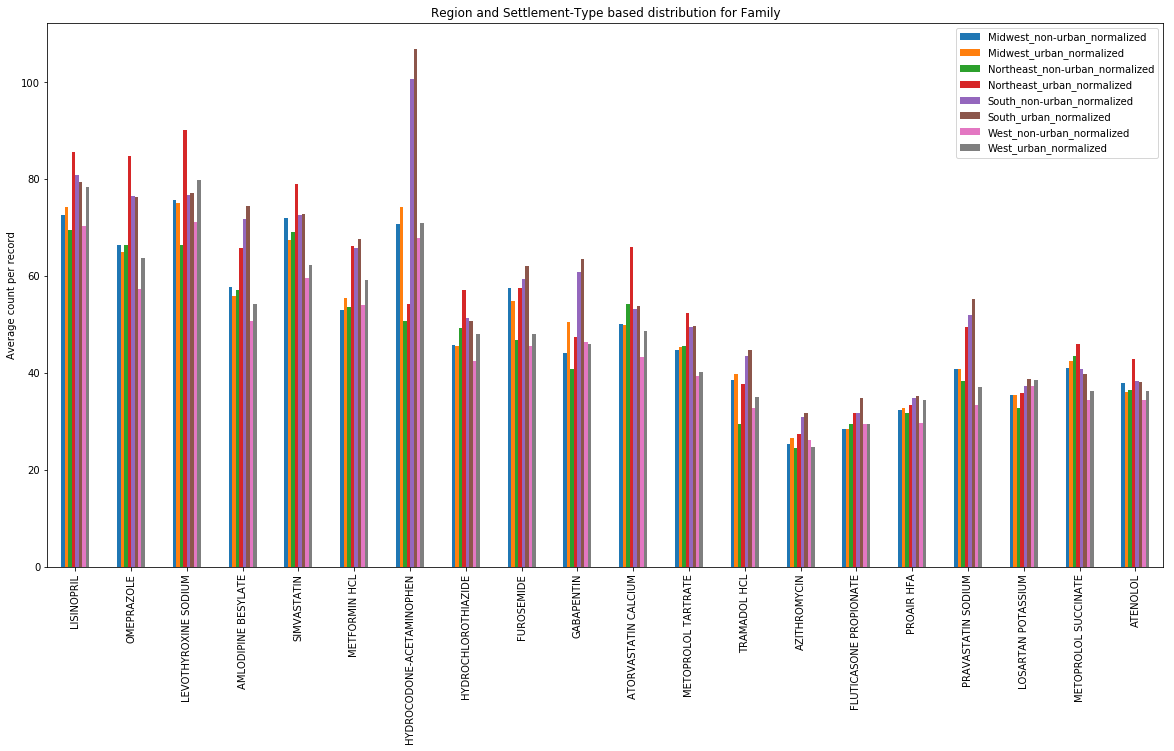

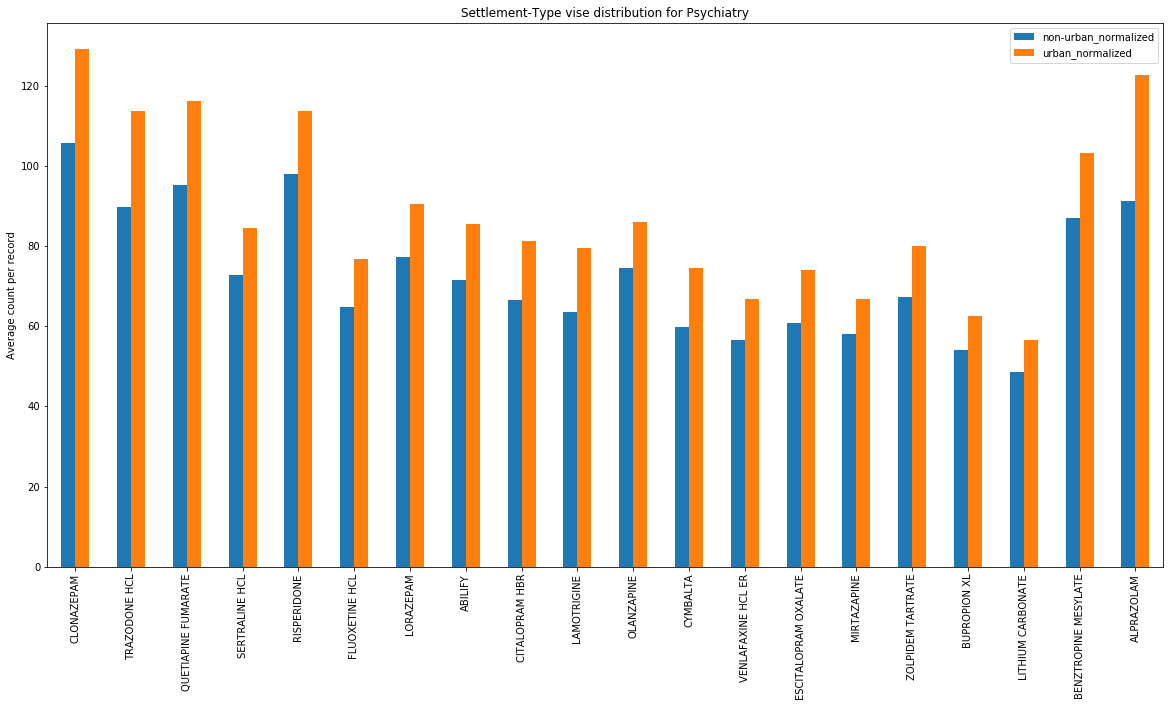

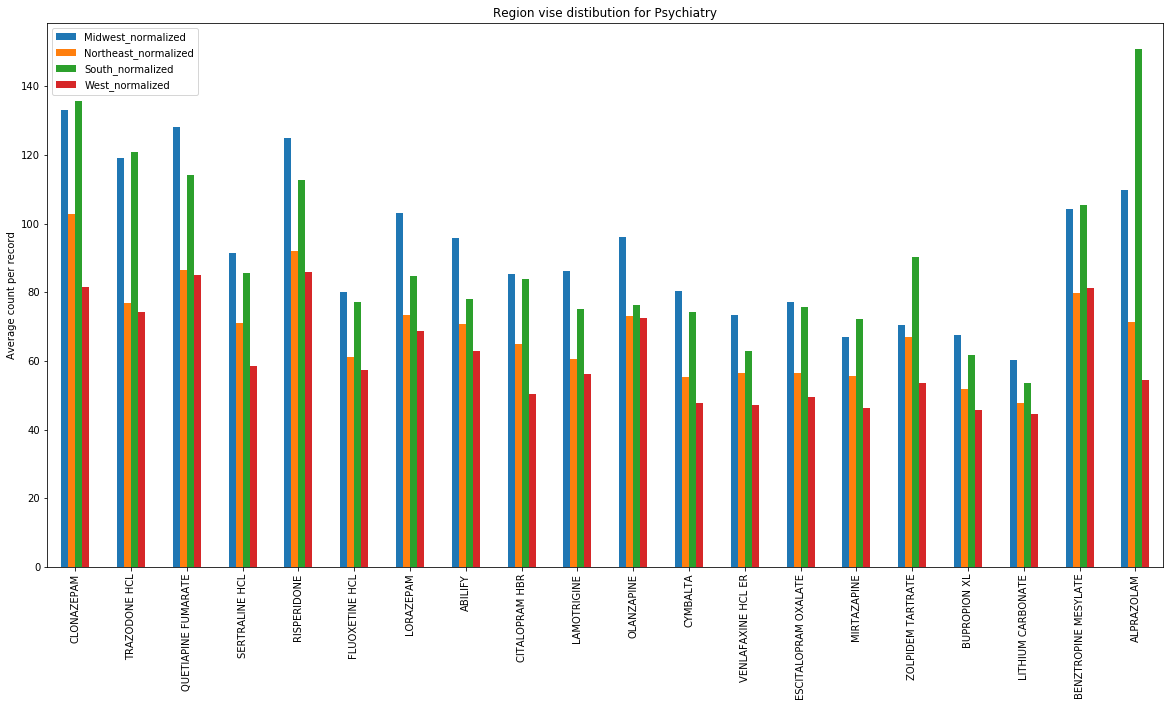

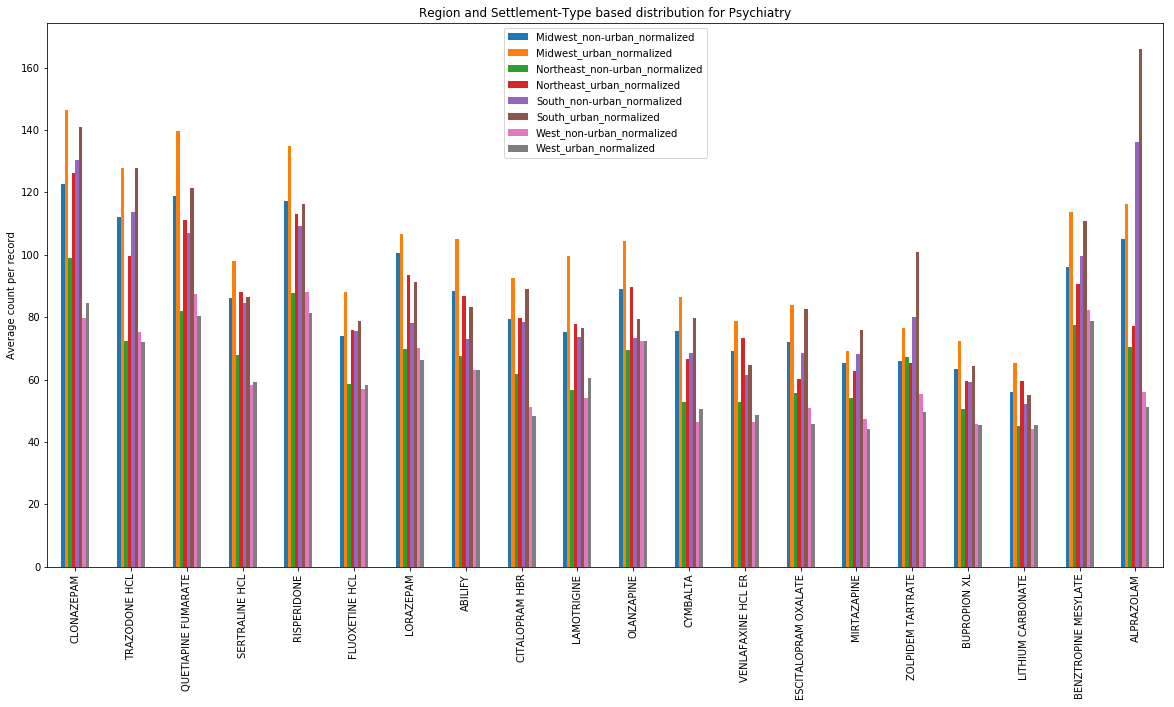

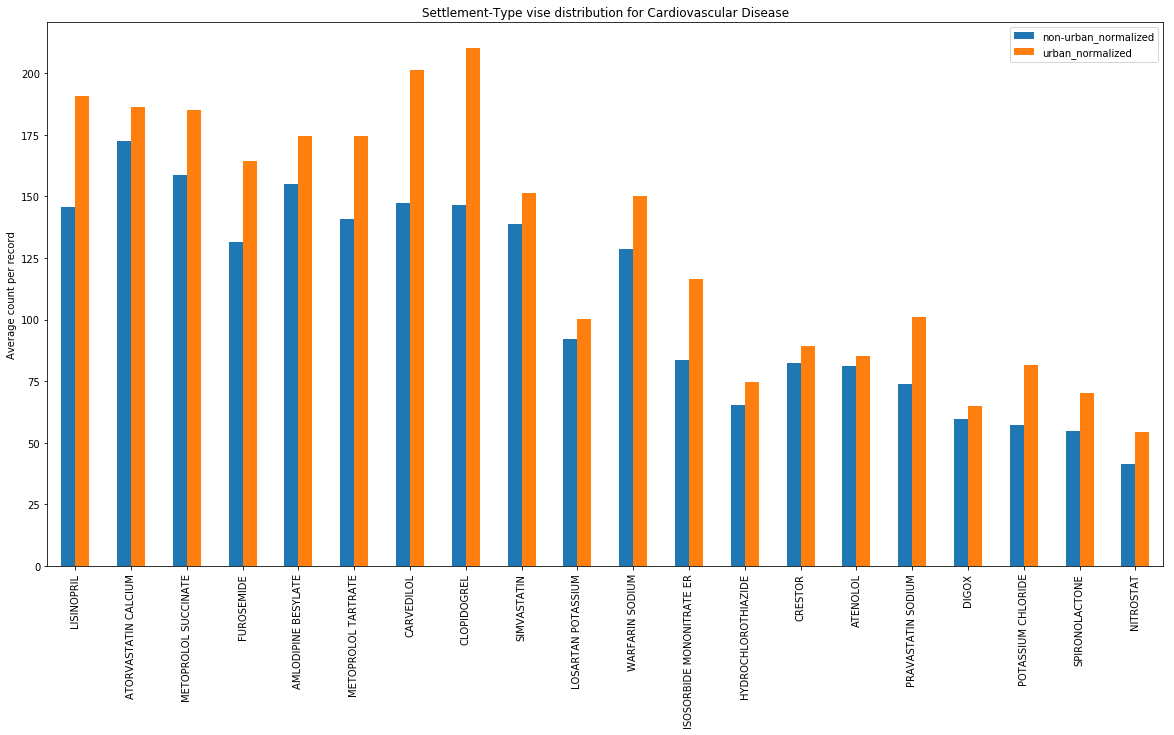

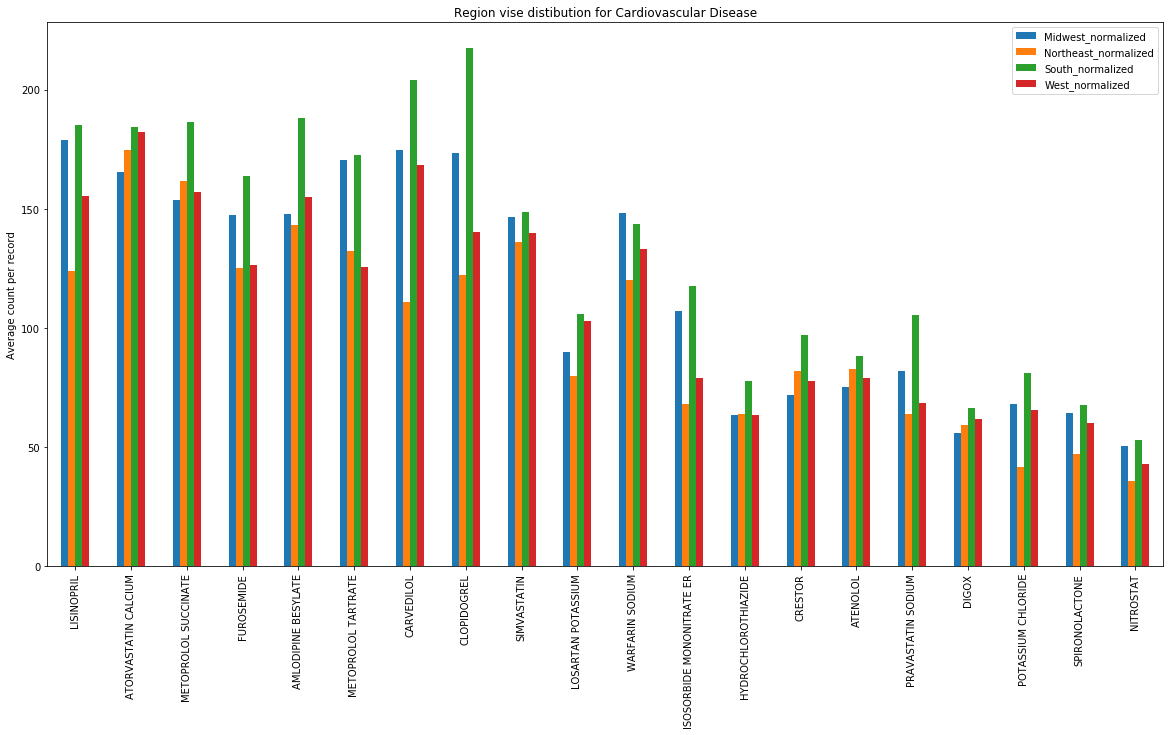

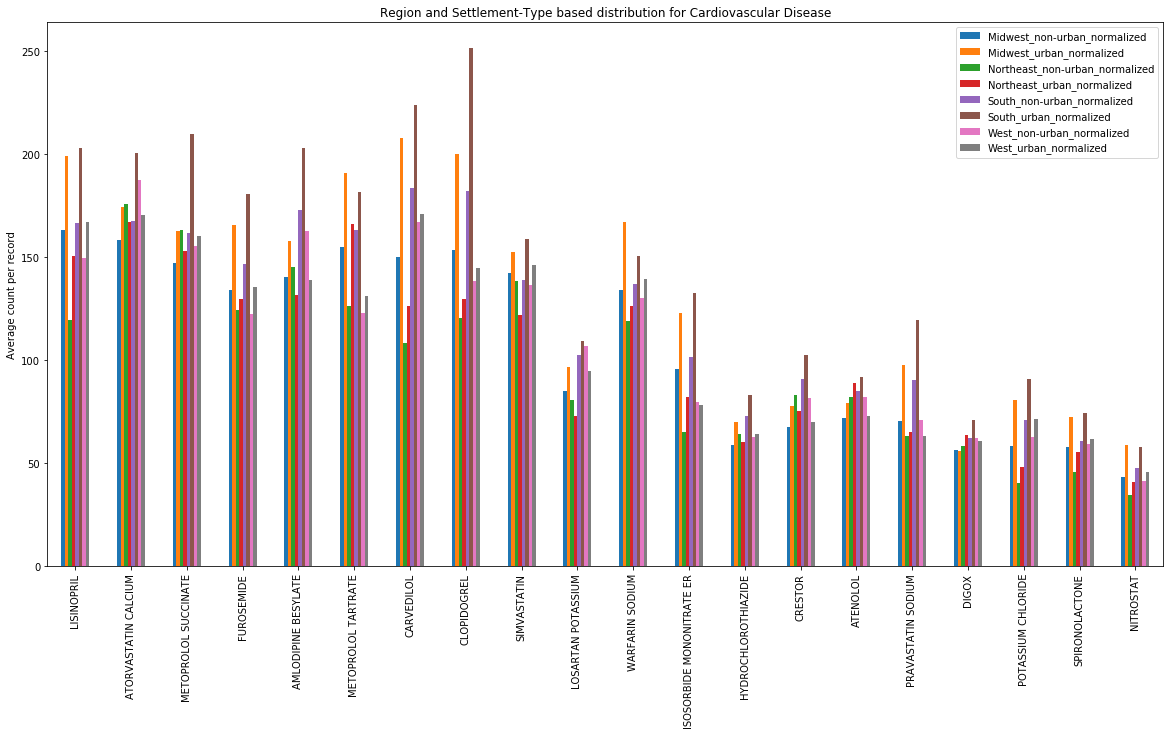

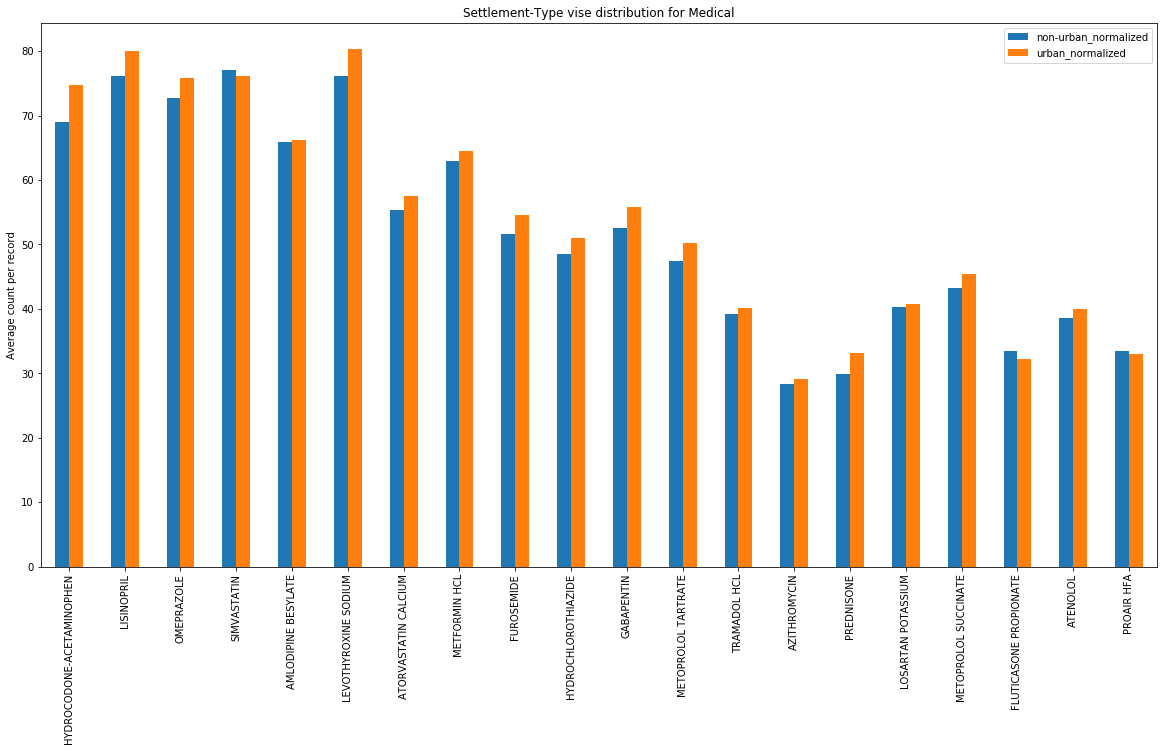

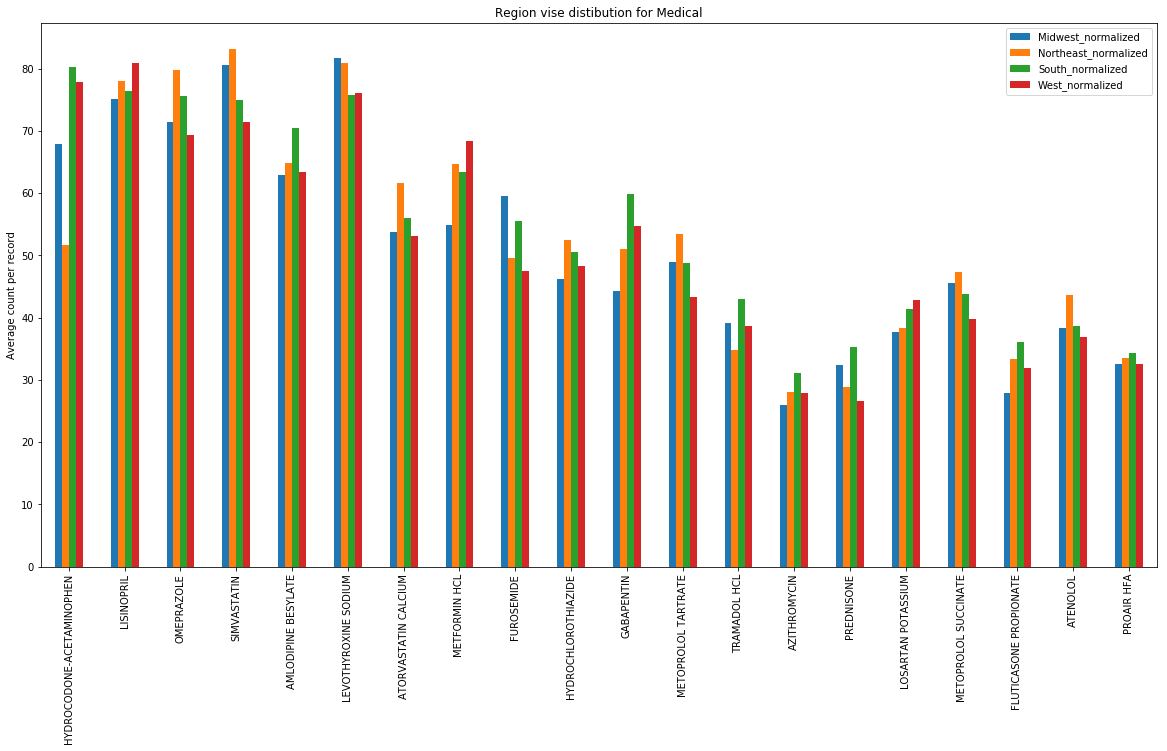

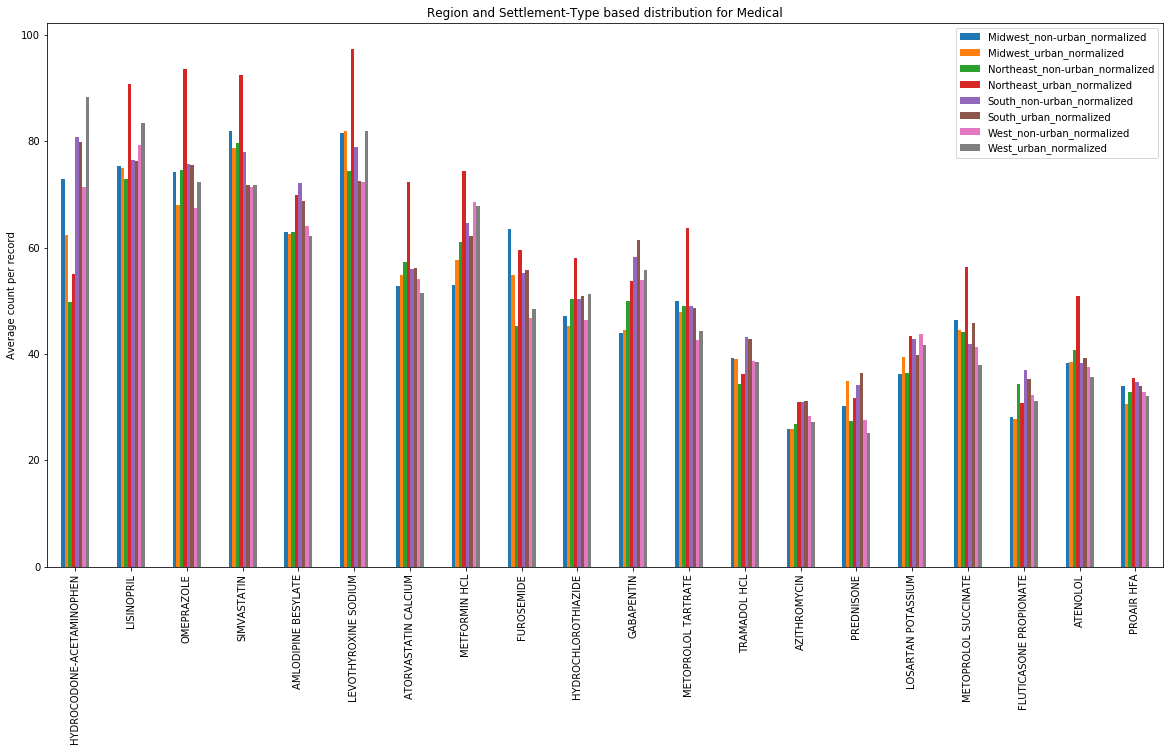

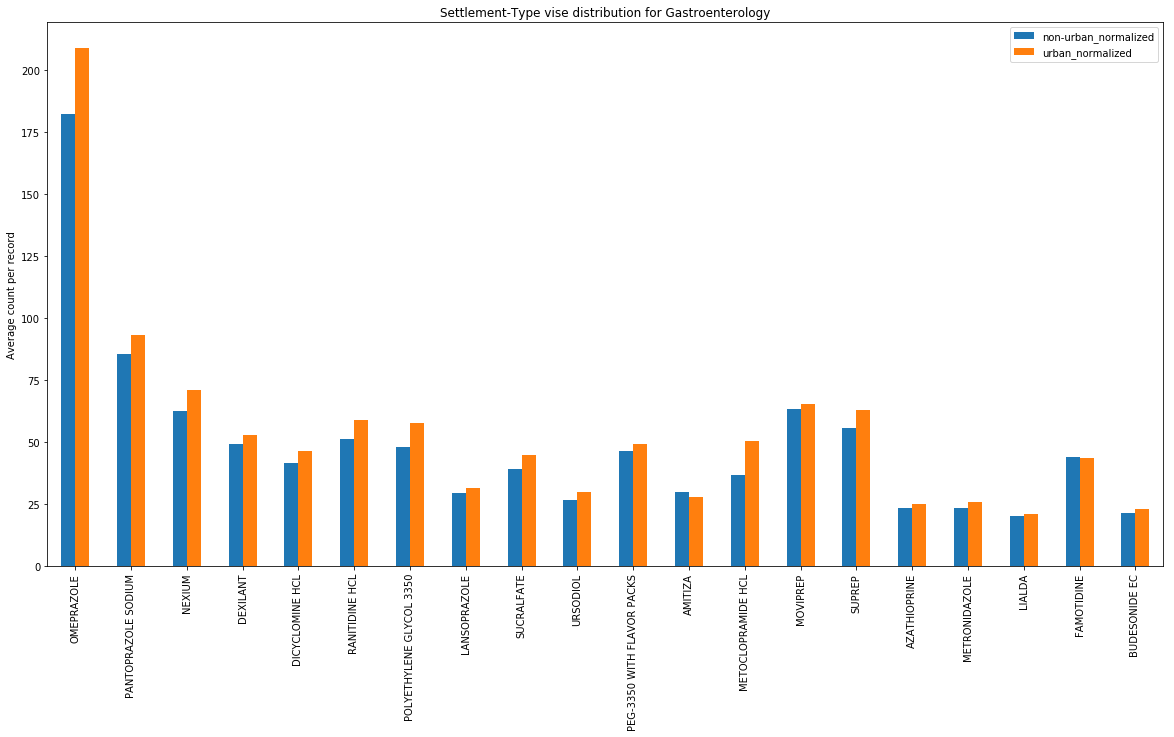

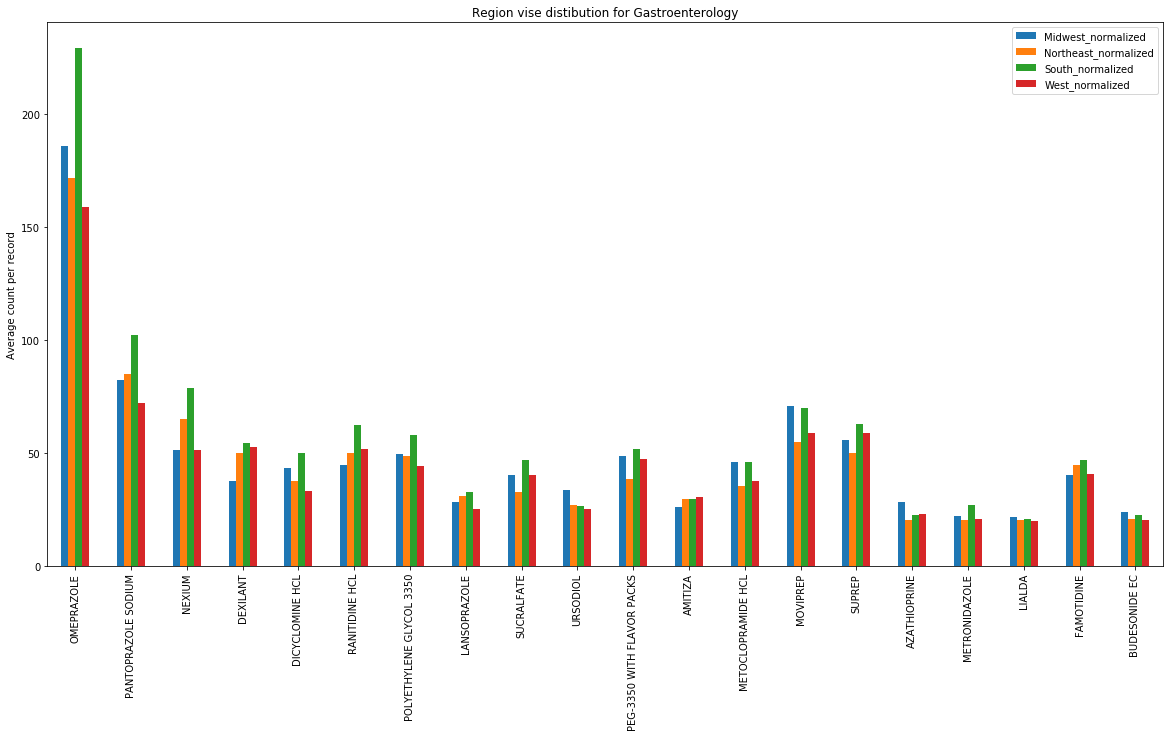

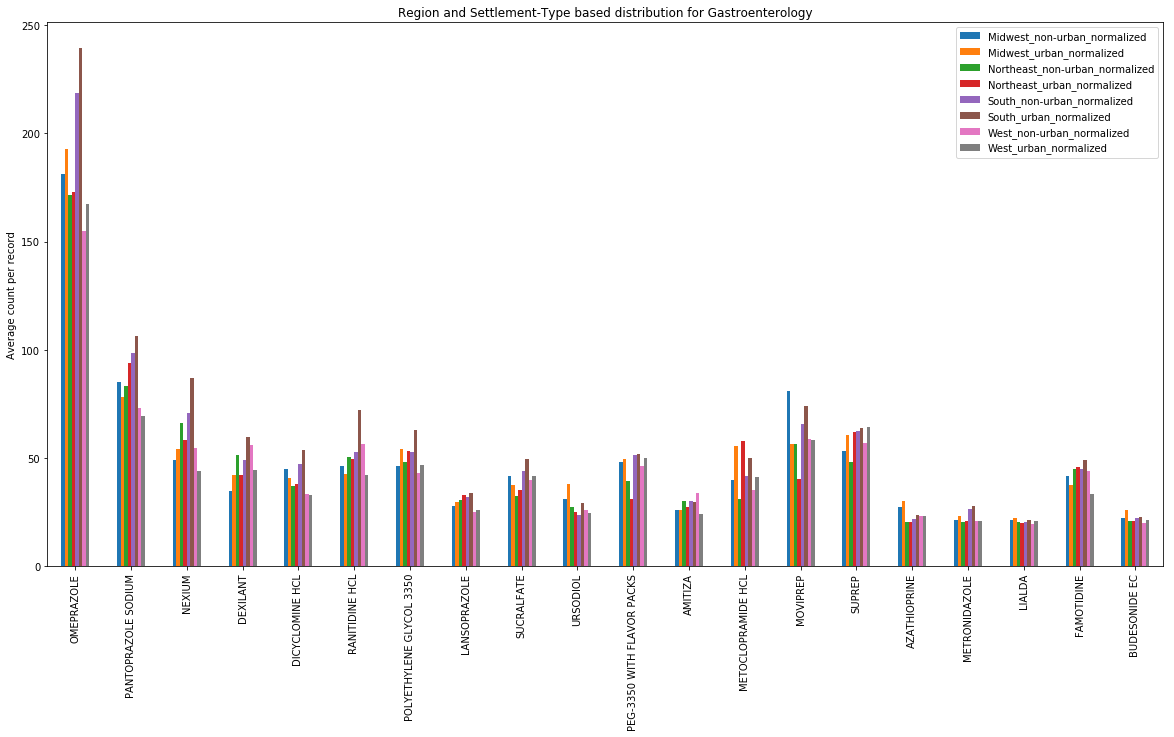

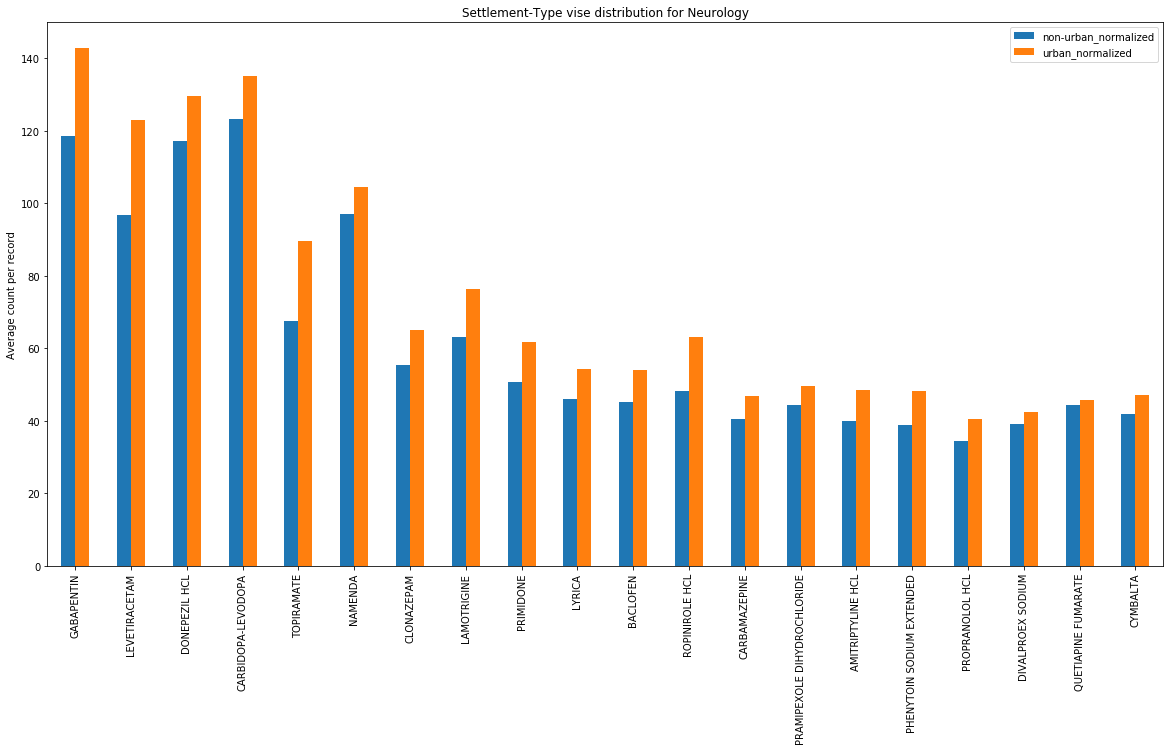

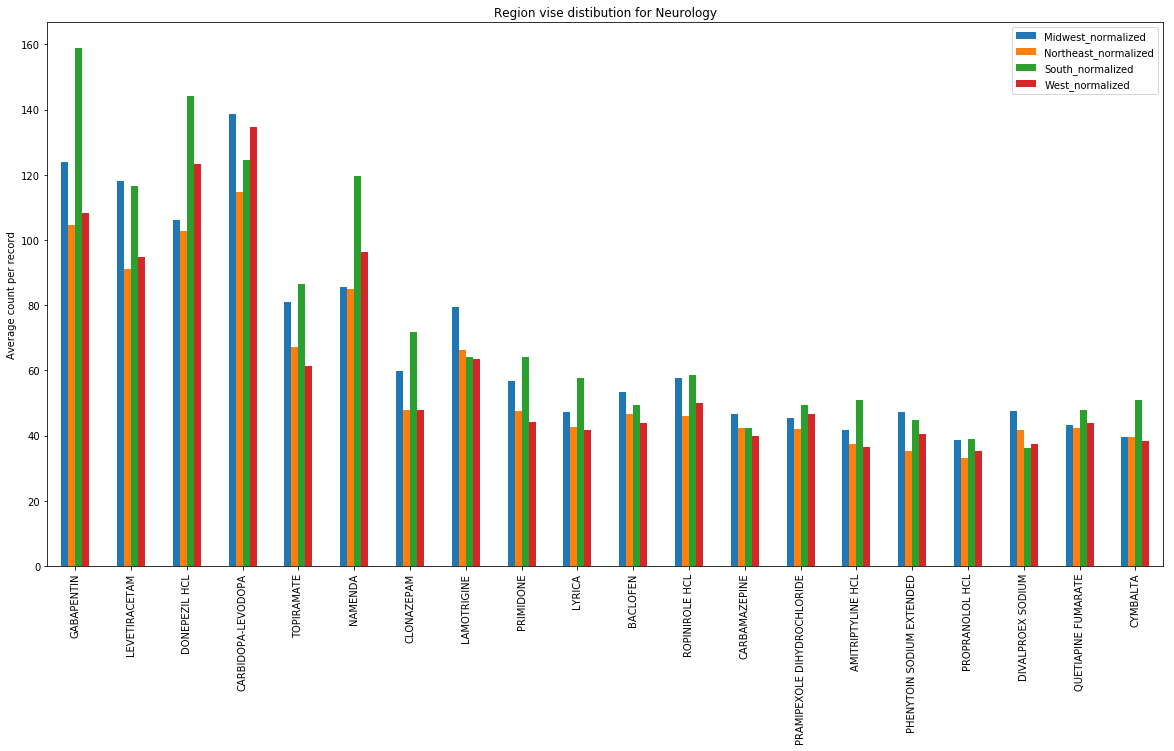

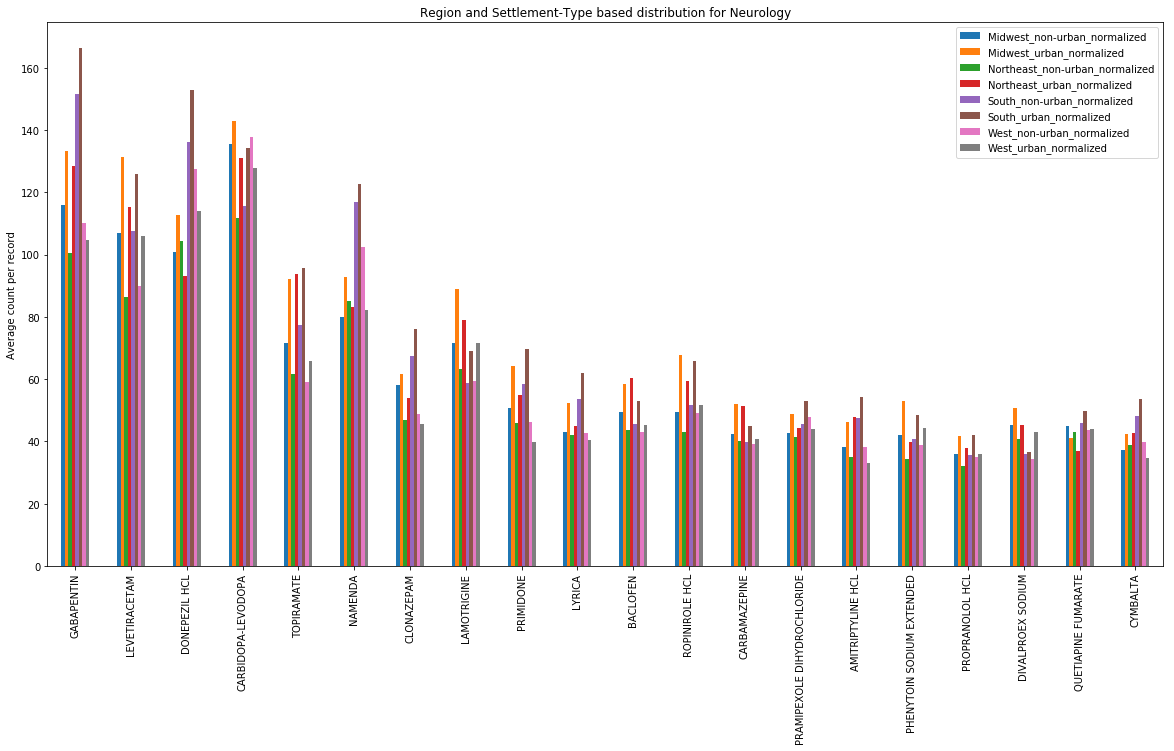

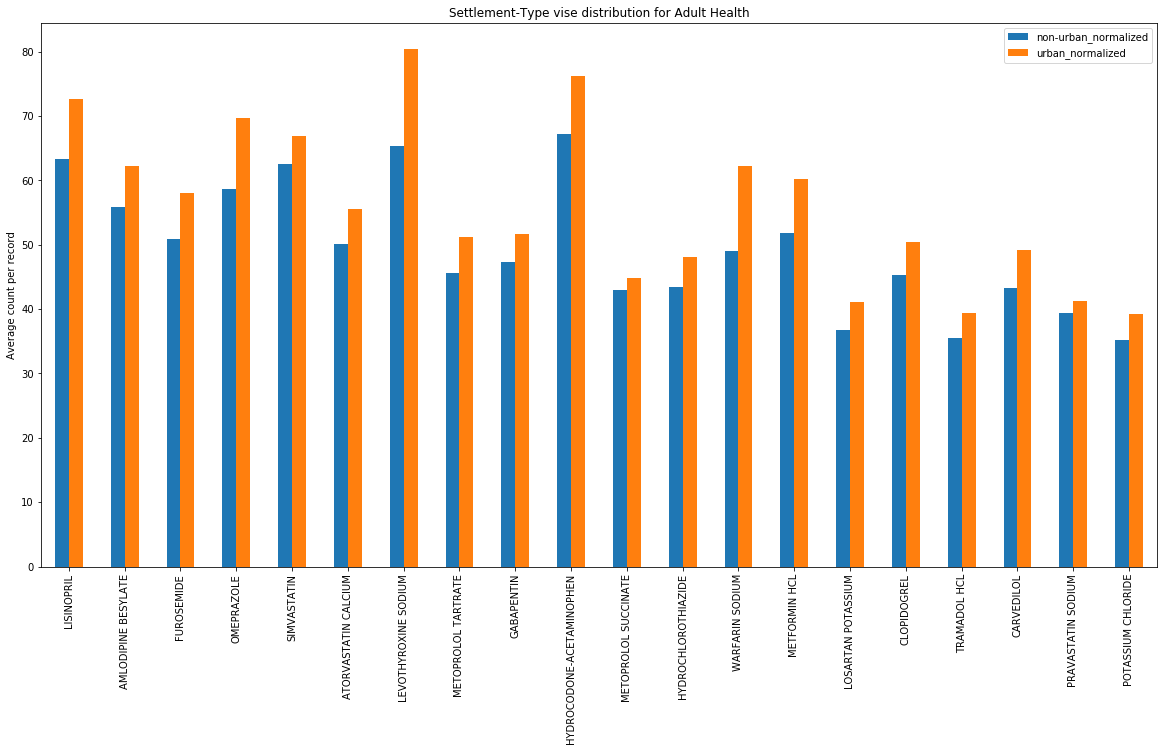

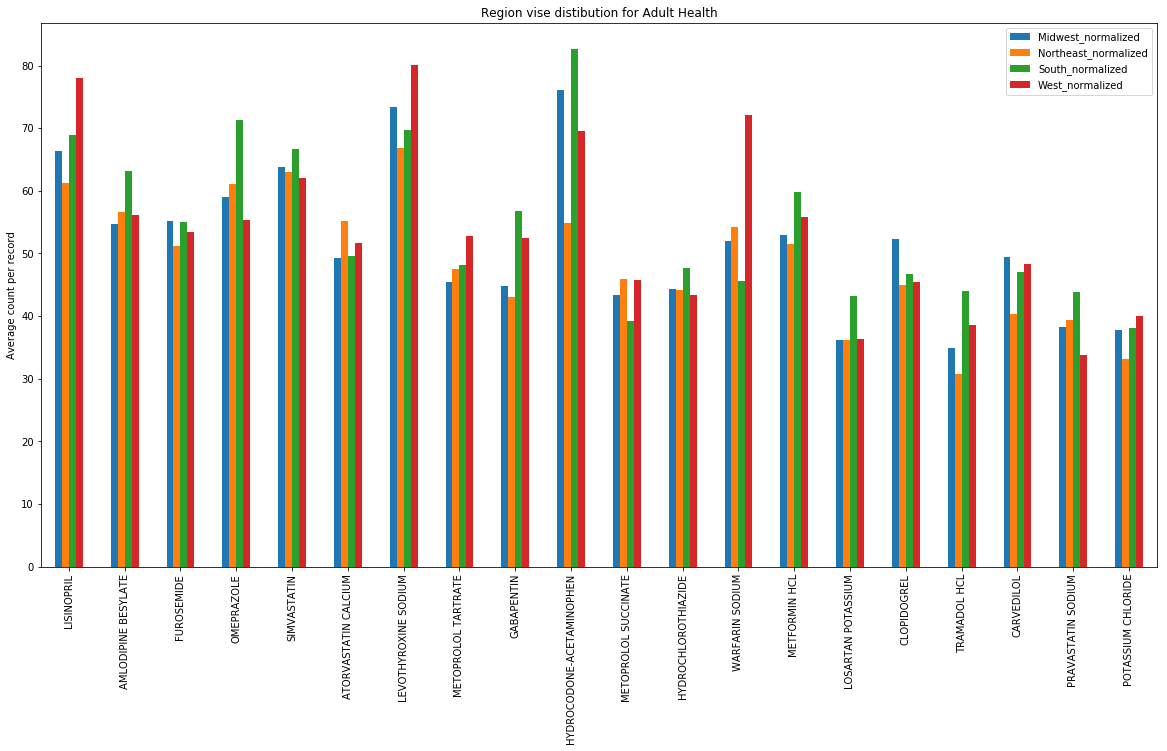

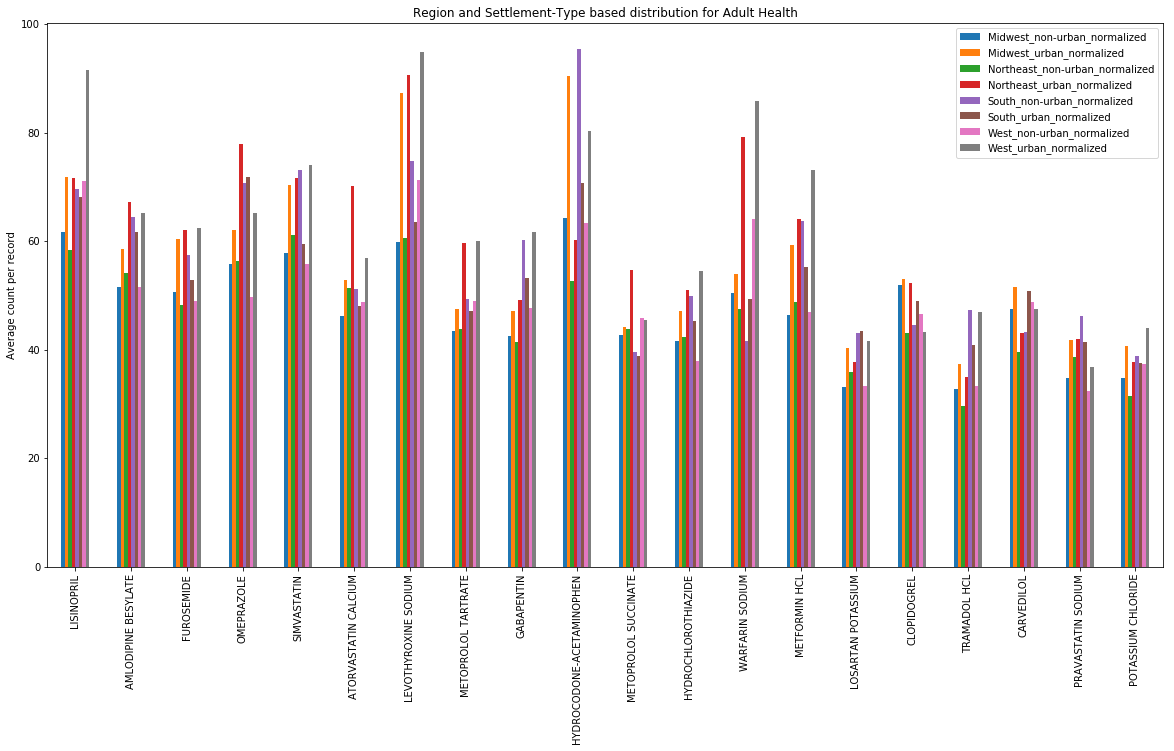

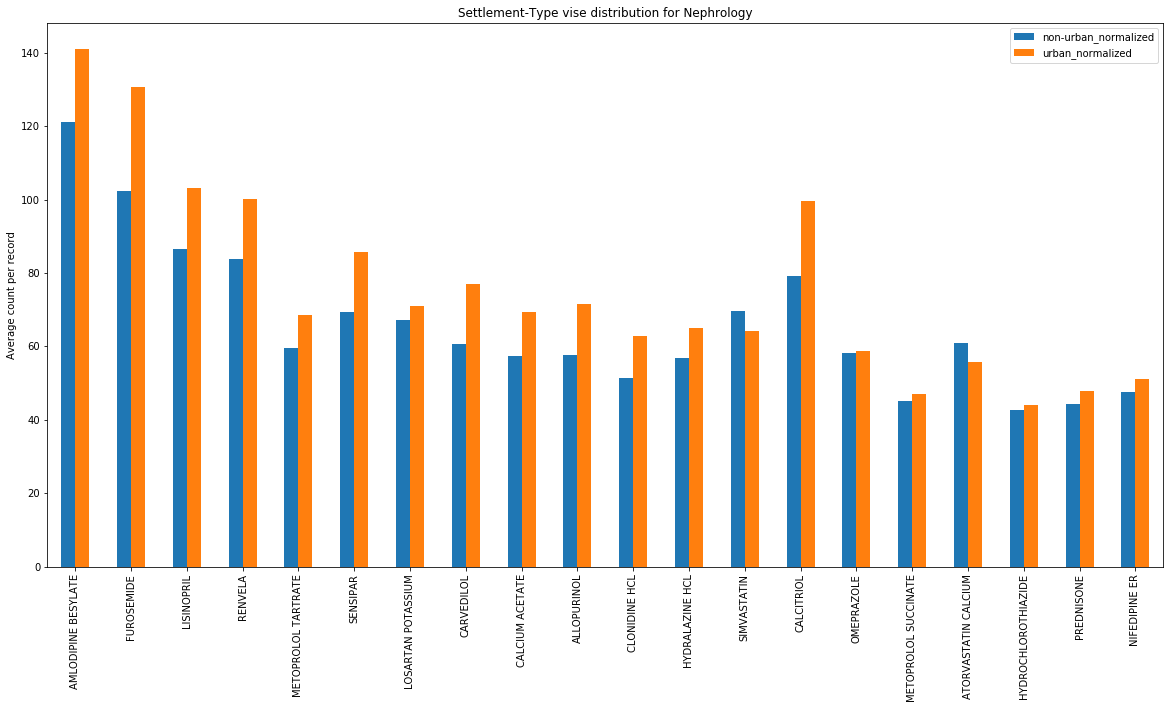

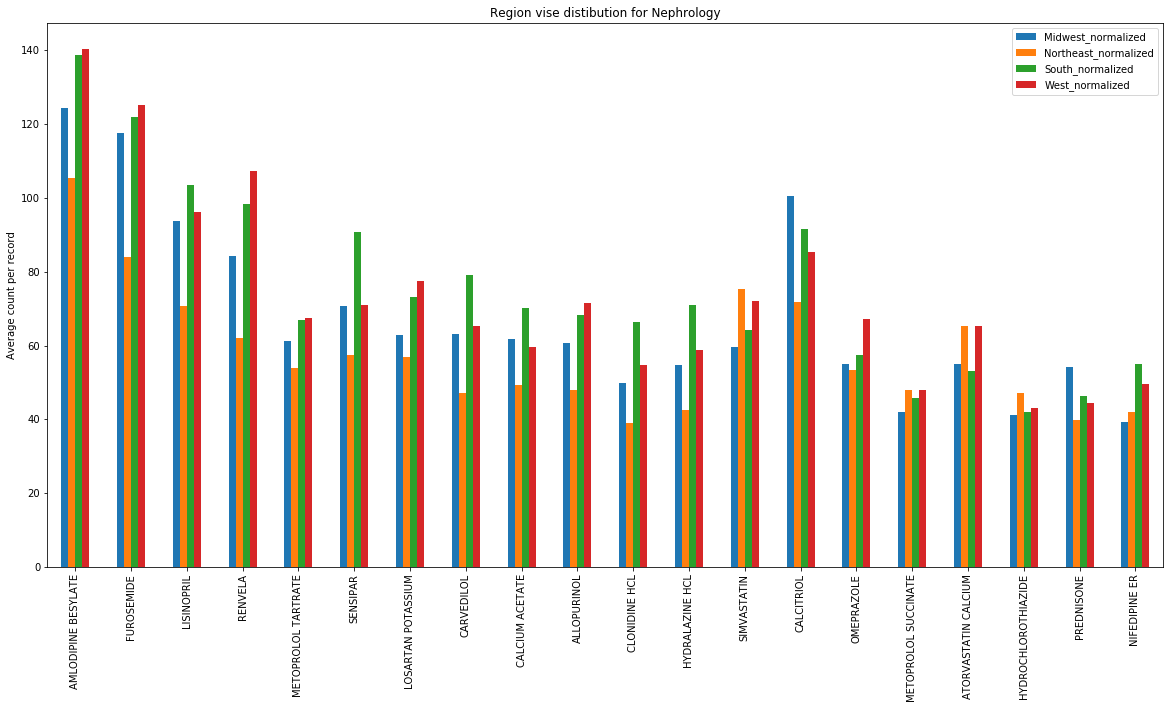

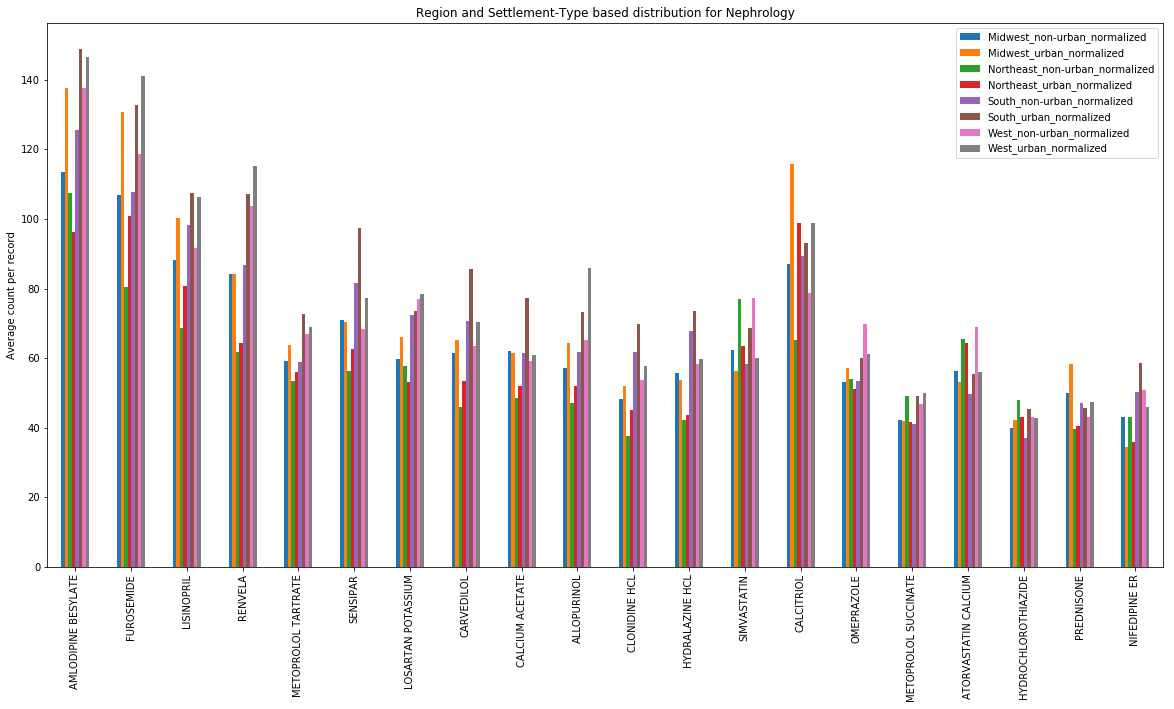

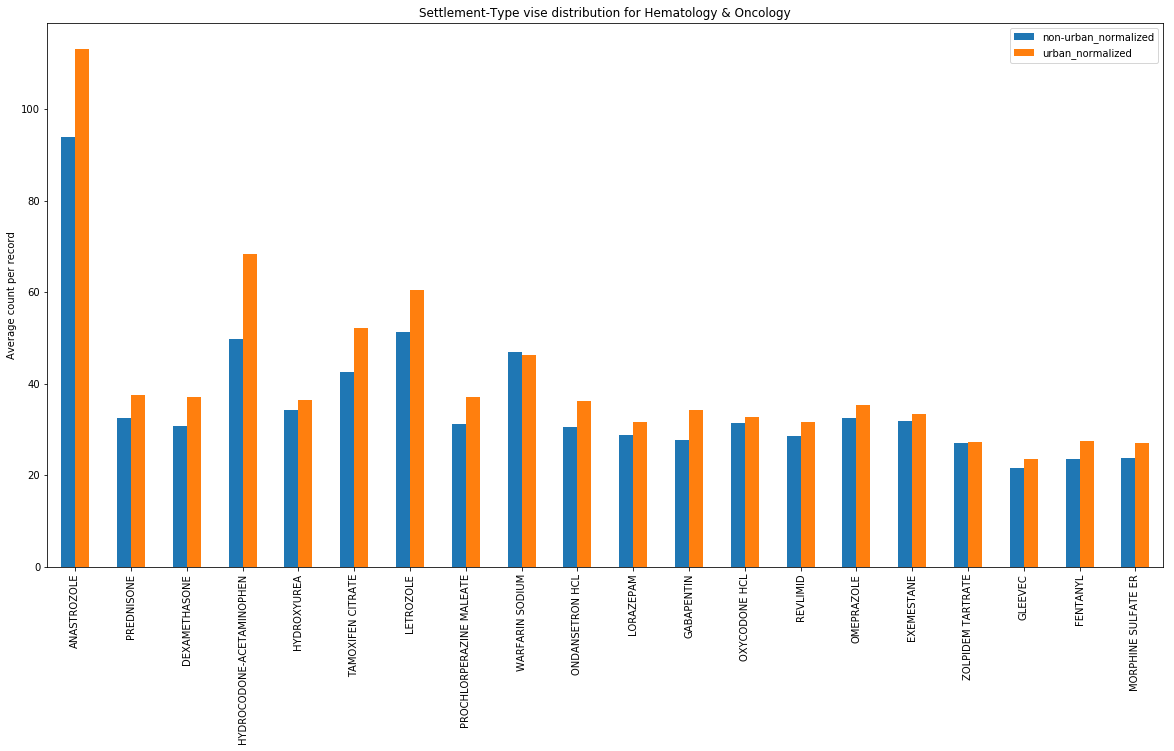

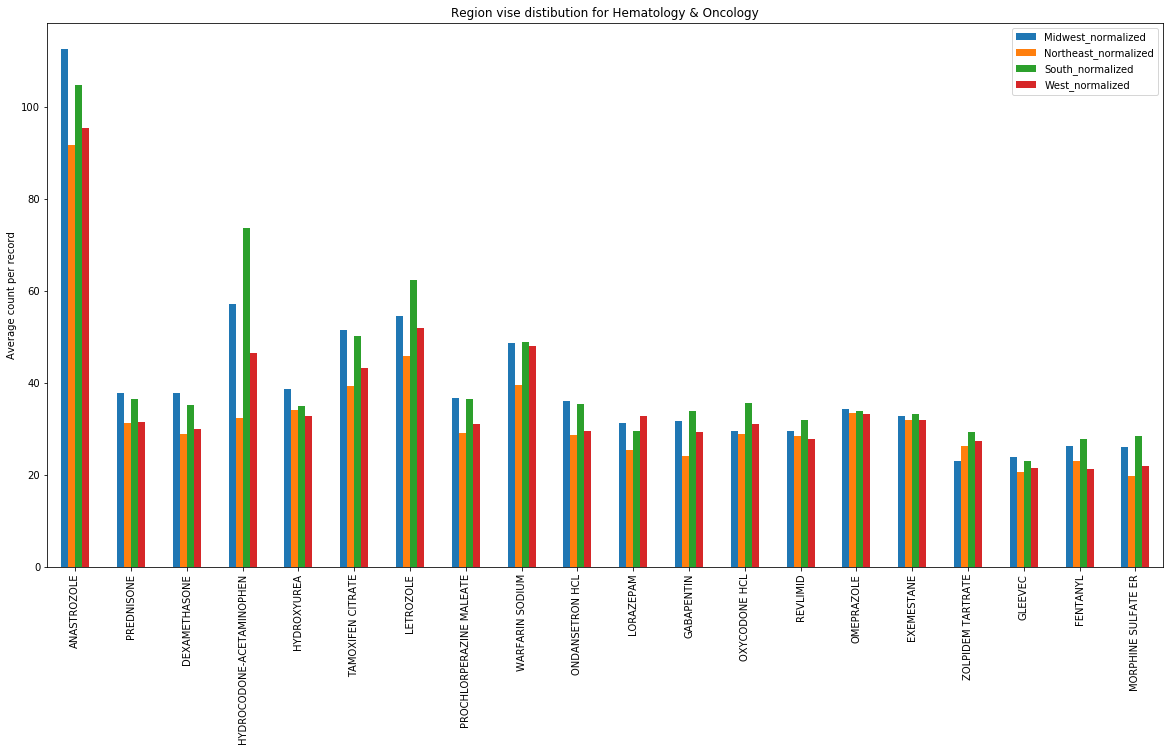

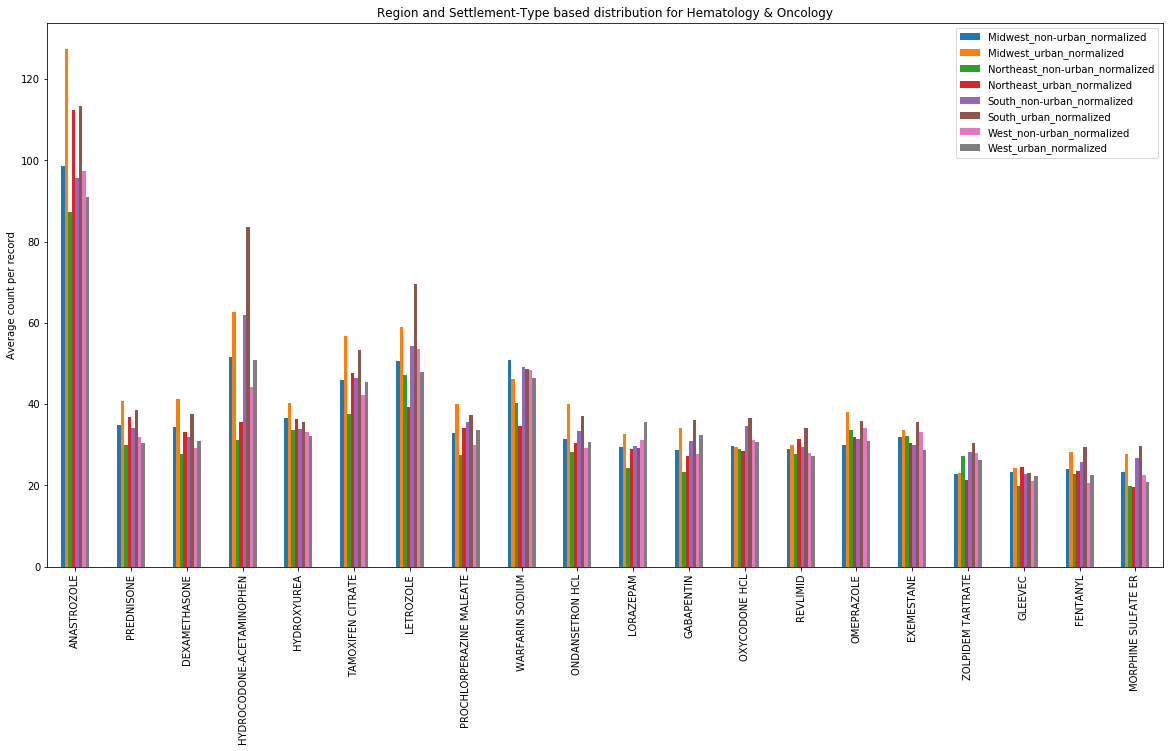

In [47]:
for specialty in top10specialties['specialty']:
    plotDistributions(specialty)

for any drug ideally it is expected that irrespective of the settlement type of the doctor the drug will be perscribed in equal measures. But In the above graphs we can clearly see that some of the drugs are prescribe more in some settlement compared to others.

# Implementation

In [48]:
dataframe_main.columns.values[-10:]

array([u'ZYTIGA', u'ZYVOX', 'npi', u'brand_name_rx_count', u'gender',
       u'generic_rx_count', u'region', u'settlement_type', u'specialty',
       u'years_practicing'], dtype=object)

##### delete all the specialties with less than 900 records

In [49]:
%%time
dataframe_main.drop(['npi', 'brand_name_rx_count', 'gender', 'generic_rx_count', 'region', 'settlement_type', 'years_practicing'], axis=1,inplace=True)


#FOR THIS CAPSTONR PROJECT PURPOSE WE WILL CONSIDER ONLY TOP FIVE SPECIALITIES(WHICH CORESPONDS TO 2/3RD'S) FOR THE LACK OF COMPUTATIONAL INFRASTRUCTURE
tempList = []
df_df_specialty_countlessthan400 = df_specialty_count.query('counts < 900')
for i in df_df_specialty_countlessthan400['specialty']:
    indices = dataframe_main.loc[dataframe_main['specialty'] == i].index.tolist()
    tempList.append(indices)

#collect all the indices for these specialties to remove from the df_dataframe_main

indicesToDrop = [item for sublist in tempList for item in sublist]
dataframe_main.drop(dataframe_main.index[indicesToDrop], inplace=True)
dataframe_main.dropna(axis=1,how='all', inplace=True)

CPU times: user 1min 39s, sys: 7.63 s, total: 1min 47s
Wall time: 1min 48s


##### transform the target lable to numeric form 

In [50]:
from sklearn.preprocessing import LabelEncoder

label = dataframe_main.pop('specialty')

le = LabelEncoder()
y = le.fit_transform(label)

In [51]:
dataframe_main.fillna(value=0, inplace=True)


## Benchmark

##### use GaussianNb to create benchmark score

In [52]:
%%time
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split


X_train,X_test,y_train,y_true = train_test_split(dataframe_main , y, test_size=0.2, random_state=42)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

print "Accuracy Rate using a simple GaussianNB is: %f" % accuracy_score(y_true, y_pred)

Accuracy Rate using a simple GaussianNB is: 0.183314
CPU times: user 1min 28s, sys: 43 s, total: 2min 11s
Wall time: 2min 13s


#### traninng and testing the xgboost model

In [ ]:
%%time

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score



tfidf =TfidfTransformer(norm=u'l2', use_idf=True, smooth_idf=True, sublinear_tf=False)
data =tfidf.fit_transform(dataframe_main.values)

nmf = NMF(n_components=50, init='random', random_state=0, verbose=0)
boost_input = nmf.fit_transform(data, y=y)

X_train,X_test,y_train,y_true = train_test_split(boost_input,y, test_size=0.2, random_state=42)

model = XGBClassifier(silent=True,seed=42, colsample_bylevel=0.5, scale_pos_weight=0.1 , nthread=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


print "Accuracy Score for XGBoost with colsample_bylevel is: %f" % accuracy_score(y_true, y_pred)

Accuracy Score for XGBoost with colsample_bylevel is: 0.696744
CPU times: user 2h 43min, sys: 4min 7s, total: 2h 47min 8s
Wall time: 30min 35s


In [ ]:
model = XGBClassifier(silent=True,seed=42, colsample_bylevel=0.6, scale_pos_weight=0.1 , nthread=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


print "Accuracy Score for XGBoost with colsample_bylevel=0.6  is: %f" % accuracy_score(y_true, y_pred)

Accuracy Score for XGBoost with colsample_bylevel=0.6  is: 0.697158


In [ ]:
model = XGBClassifier(silent=True,seed=42, colsample_bylevel=0.7, scale_pos_weight=0.1 , nthread=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


print "Accuracy Score for XGBoost with colsample_bylevel=0.7 is: %f" % accuracy_score(y_true, y_pred)

Accuracy Score for XGBoost with colsample_bylevel=0.7 is: 0.696193
